## Importing librairies

In [1]:
import pickle
import os 
import json
import string
import requests
from IPython.display import clear_output

In [2]:
!pip install langdetect
!pip install names-dataset
!pip install bertopic
!pip install Wikidata
!pip install wordcloud
!pip install pyLDAvis
!pip install NRCLex
!pip install empath
clear_output()

In [3]:
# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from wikidata.client import Client
from tqdm import tqdm
from collections import Counter

# Preprocessing
from langdetect import detect
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from names_dataset import NameDataset
from itertools import chain 
import seaborn as sns

# Stats
import scipy.stats as stats

# LDA
from gensim.models import Phrases
from gensim import corpora
from gensim import models

# WordCloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

# Topic visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# BERTopic
from bertopic import BERTopic

# Sentiment analysis
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex

# Concerns
import random
from empath import Empath

In [4]:
from tqdm import tqdm_notebook
from tqdm import tqdm
tqdm.pandas()
clear_output()

In [5]:
from nltk import download
download('averaged_perceptron_tagger')
download('wordnet')
download('omw-1.4')
download('punkt')
download('stopwords')
clear_output()

## References

[[1]](http://www.cs.cmu.edu/~ark/personas/) CMU Movie Summary Corpus webpage  
[[2]](http://www.cs.cmu.edu/~dbamman/pubs/pdf/bamman+oconnor+smith.acl13.pdf) _Learning Latent Personas of Film Characters_, David Bamman, Brendan O'Connor and Noah A. Smith, ACL 2013, Sofia, Bulgaria, August 2013 <br />
[[3]](https://www.nltk.org/) NLKT documentation 

# Table of contents
### [1. Metadata](#1)

&nbsp;&nbsp;&nbsp;**[1.1 The data](#1.1)**

&nbsp;&nbsp;&nbsp;**[1.2 Cleaning the dictionaries](#1.2)**

&nbsp;&nbsp;&nbsp;**[1.3 Duplicate values](#1.3)**

&nbsp;&nbsp;&nbsp;**[1.4 Missing values](#1.4)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.1 Recovering Ethnicities](#1.4.1)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4.2 Recovering missing Actor names ](#1.4.2)


### [2. Plot Summaries and Metascores](#2)

&nbsp;&nbsp;&nbsp;**[2.1 Preprocessing](#2.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.1 Missing plot summaries check](#2.1.1)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.2 Cleaning](#2.1.2)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.3 Tokenization](#2.1.3)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.4 PoS tagging](#2.1.4)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.5 Lemmatization](#2.1.5)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.6 Regrouping tokens and removing stop words](#2.1.6)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.7 Integration into movies dataset ](#2.1.7)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1.8 Preprocessing results](#2.1.8)

&nbsp;&nbsp;&nbsp;**[2.2 Importing Metascore](#2.2)**

&nbsp;&nbsp;&nbsp;**[2.3 Initial analysis](#2.3)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.1 Plot summaries structure](#2.3.1)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.2 Most common tokens](#2.3.2)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.3 Movie genres clustering](#2.3.3)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.4 Words polarity](#2.3.4)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.5 Ratings preliminary visualization](#2.3.5)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3.6 WordCloud](#2.3.6)

### [3. Topic extraction](#3)

&nbsp;&nbsp;&nbsp;**[3.1 LDA](#3.1)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.1 Data preparation](#3.1.1)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.2 Implementation](#3.1.2)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.3 Model evaluation](#3.1.3)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.4 Resulting topics](#3.1.4)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.5 Topic Visualizations](#3.1.5)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1.6 Assigning topics to movies](#3.1.6)

&nbsp;&nbsp;&nbsp;**[3.2 BERTopic](#3.2)**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1 Data preparation](#3.2.1)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2 Implementation](#3.2.2)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.3 Model evaluation](#3.2.3)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.4 Resulting topics](#3.2.4)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.5 Topic Visualizations](#3.2.5)<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.6 Assigning topics to movies](#3.2.6)

### [4. Sentiment analysis](#4)

&nbsp;&nbsp;&nbsp;**[4.1 Positive-Negative-Neutral sentiments](#4.1)**

&nbsp;&nbsp;&nbsp;**[4.2 Multi-sentiment](#4.2)**

### [5. Concerns](#4)
&nbsp;&nbsp;&nbsp;**[5.1 Concerns creation and description](#5.1)**

&nbsp;&nbsp;&nbsp;**[5.2 Processing tokens for Empath](#5.2)**

&nbsp;&nbsp;&nbsp;**[5.3 Empath analysis](#5.3)**

# 1. Metadata <a id='1'></a>

## 1.1 The Data  <a id='1.1'></a>

`movie.metadata.tsv.gz` [3.4 M]


Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`character.metadata.tsv.gz` [14 M]

Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [6]:
movies_path = "data/movie.metadata.tsv"
characters_path = "data/character.metadata.tsv"

# naming the columns with adequate names
movies_column_names = ["WikiMovieID", "FreeMovieID", "Title", "ReleaseDate", "Revenue", "Runtime", "Languages", "Countries", "Genres"]
characters_column_names = ["WikiMovieID", "FreeMovieID", "ReleaseDate", "CharName", "ActorDOB", "ActorGender", "ActorHeight", "FreeEthnicityID",\
                           "ActorName", "ActorAgeRelease", "FreeMapID", "FreeCharID", "FreeActorID"]

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)

display(movies.head())
display(characters.head())

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,FreeEthnicityID,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


#### Initial remarks :
- `ReleaseDate`doesn't have a standard format.
- `Languages`, `Countries`and `Genres`columns have their values in a dictionary of form : `{Freebase id : Actual name}`

#### Dataset length
We verify that the given dataset entries are indeed as much as we expect : 

In [7]:
n_mov = len(movies)
n_char = len(characters)
print('Number of rows in the movie.metadata dataset :', n_mov)
print('Number of rows in the character.metadata dataset :', n_char)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the character.metadata dataset : 450669


## 1.2 Cleaning Dictionaries  <a id='1.2'></a>

Columns `Languages`, `Countries`, `Genres` are dictionaries containing both the Freebase ID and the actual name, for each entry. We will keep only the names for the sake of clarity.

In [8]:
def extract_values(column):
    values = []
    column=json.loads(column)
    for key in column:
        values.append(column[key])
    return values

movies.Languages = movies.Languages.apply(extract_values)
movies.Countries = movies.Countries.apply(extract_values)
movies.Genres = movies.Genres.apply(extract_values)

display(movies[["Languages", "Countries", "Genres"]].head())

,Languages,Countries,Genres
0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,[German Language],[Germany],[Drama]


## 1.3 Duplicate values  <a id='1.3'></a>

Starting with the characters dataset we only care if a whole row is duplicated as there is no specific feature that we prohibit from happenning twice.

In [9]:
print("Duplicated rows in characters : {}".format(characters.duplicated().sum()))

Duplicated rows in characters : 0


As for the movies dataset we have to be more careful as we don't want the same movie appearing twice under different release date or freebase id for example.

In [10]:
print("Duplicated rows in :")
for column in movies.columns:
    duplicated_rows = movies[column].duplicated().sum()
    print("\t{} : {} ".format(column, duplicated_rows))

Duplicated rows in :
	WikiMovieID : 0 
	FreeMovieID : 0 
	Title : 6263 
	ReleaseDate : 61351 
	Revenue : 74378 
	Runtime : 81143 
	Languages : 79924 
	Countries : 79617 
	Genres : 57924 


The fact that `Title` has a duplicated rows is a bit concerning. We see however than `WikiMovieID` and movies `FreeMovieID` have only unique entries. This indicates us that movies can have the same title while being actually different movies.

## 1.4 Missing values  <a id='1.4'></a>

We want to see which columns have missing entries, and for those columns what is the percentage of missing entries.

In [11]:
movies.isna().any()

WikiMovieID    False
FreeMovieID    False
Title          False
ReleaseDate     True
Revenue         True
Runtime         True
Languages      False
Countries      False
Genres         False
dtype: bool

For the movies dataset, only `ReleaseDate`, `Revenue` and `Runtime` have missing entries.

In [12]:
mov_missing = movies[['ReleaseDate', 'Revenue', 'Runtime']].isna().sum()
print('Percentage of missing entries in the movie dataset (%):')
for x in range(len(mov_missing.values)):
    print("   ",mov_missing.index[x], ':', round(100*mov_missing.values[x]/n_mov, 2))

Percentage of missing entries in the movie dataset (%):
    ReleaseDate : 8.44
    Revenue : 89.72
    Runtime : 25.02


90% of the revenues are non specified. We won't use this feature in our project.  
8% of the release dates and 25% of the runtimes are missing, we can fill them if we find the correct ones.

In [13]:
characters.isna().any()

WikiMovieID        False
FreeMovieID        False
ReleaseDate         True
CharName            True
ActorDOB            True
ActorGender         True
ActorHeight         True
FreeEthnicityID     True
ActorName           True
ActorAgeRelease     True
FreeMapID          False
FreeCharID          True
FreeActorID         True
dtype: bool

In [14]:
char_missing = characters[['ReleaseDate', 'CharName', 'ActorDOB', 'ActorGender', 'ActorHeight', 'FreeEthnicityID', 'ActorName',
                           'ActorAgeRelease', 'FreeCharID', 'FreeActorID']].isna().sum()
print('Percentage of missing entries in the characters dataset (%):')
for x in range(len(char_missing.values)):
    print("   ",char_missing.index[x], ':', round(100*char_missing.values[x]/n_char, 2))

Percentage of missing entries in the characters dataset (%):
    ReleaseDate : 2.22
    CharName : 57.22
    ActorDOB : 23.55
    ActorGender : 10.12
    ActorHeight : 65.65
    FreeEthnicityID : 76.47
    ActorName : 0.27
    ActorAgeRelease : 35.08
    FreeCharID : 57.22
    FreeActorID : 0.18


### 1.4.1 Recovering Ethnicities  <a id='1.4.1'></a>

`Ethnicity` only has the ID of the Freebase database whose API is currently depreciated. To solve this problem we use the [Freebase/Wikidata Mappings](https://developers.google.com/freebase#freebase-wikidata-mappings) which as the name suggests maps the given Freebase Ids to WikiData.

- Note : The data has been created based on the Wikidata-Dump of October 28, 2013, and contains only those links that have at least two common Wikipedia-Links and not a single disagreeing Wikipedia-Link. Since the movies/characters dataset were gathered during that time too there is no time conflict.

In [15]:
mappings_path = "data/fb2w.nt.gz"
maps = pd.read_csv(mappings_path, sep='\t', header=None, skiprows=4, names=["Freebase", "W3", "Wiki"])
display(maps.head())

,Freebase,W3,Wiki
0,<http://rdf.freebase.com/ns/m.0695j>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q6718> .
1,<http://rdf.freebase.com/ns/m.05nrg>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q538> .
2,<http://rdf.freebase.com/ns/m.0jgd>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q414> .
3,<http://rdf.freebase.com/ns/m.0d_23>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q2537> .
4,<http://rdf.freebase.com/ns/m.04g7d>,<http://www.w3.org/2002/07/owl#sameAs>,<http://www.wikidata.org/entity/Q315> .


We only need the ID and not the whole website link so we transform columns in the following way :
- Freebase : <http://rdf.freebase.com/ns/m.CODE_ID> -> /m/CODE_ID
- Wiki : <http://www.wikidata.org/entity/CODE_ID> -> CODE_ID

In [16]:
"""
Transforms the Freebase website to Freebase ID
"""
def elim_freebase(web):
    return "/m/"+web[30:-1]

"""
Transforms the Freebase website to Freebase ID
"""
def elim_wiki(web):
    return web[32:-3]

In [17]:
maps["free"] = maps.Freebase.apply(elim_freebase)
maps["wiki"] = maps.Wiki.apply(elim_wiki)

# We don't need the rest of the columns so we drop them 
maps.drop(columns = ["Freebase", "W3", "Wiki"], inplace=True)
maps.head()

,free,wiki
0,/m/0695j,Q6718
1,/m/05nrg,Q538
2,/m/0jgd,Q414
3,/m/0d_23,Q2537
4,/m/04g7d,Q315


Firstly, we get the Wikidata IDs based on the mapping we created :

In [18]:
characters = characters.merge(maps, how="left", left_on="FreeEthnicityID", right_on="free")
characters.drop(columns=["free"], inplace=True)
characters.rename(columns={"wiki":"Ethnicity_W"}, inplace=True)
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,FreeEthnicityID,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID,Ethnicity_W
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,Q49085
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


As we can see the mapping is not complete : Some Freebase IDs do not correspond to any Wikidata ID. 

In [19]:
unmapped_ethnicities = characters.Ethnicity_W.isna().sum() - characters.FreeEthnicityID.isna().sum()
print("There are {} instances of ethnicities that we could not map from Freebase to Wikidata".format(unmapped_ethnicities))
# Instances of ethnicities -> Can we replace by number of actors ethnicities? Actors with different initial ethnicities ?

There are 12992 instances of ethnicities that we could not map from Freebase to Wikidata


In [20]:
"""
Given a Wikidata ID (eg. "Q49085") returns the corresponding label 

Using this function row by row (pd.apply method) takes enormous time -> improvement? For ethnicities its ok as they're only 350 dinstinct ones
"""
def get_wikidata_label(wikidata_id):
    client = Client()
    entity = client.get(wikidata_id, load=True)
    return str(entity.label)

In [21]:
# Result is map_Ethnicity_W_to_Ethnicity_name a map between Ethnicity wikidata ID and Ethnicity label
map_Ethnicity_W_to_Ethnicity_name = pd.DataFrame(characters.Ethnicity_W.unique(), columns=["Ethnicity_W"]).dropna()

# Getting the equivalent label for each Wikidata ID
map_Ethnicity_W_to_Ethnicity_name["EthnicityName"] = map_Ethnicity_W_to_Ethnicity_name.Ethnicity_W.apply(get_wikidata_label)

In [22]:
# Assigining the missing ethnicities
characters = characters.merge(map_Ethnicity_W_to_Ethnicity_name, how="left", left_on="Ethnicity_W", right_on="Ethnicity_W").drop(columns= ["FreeEthnicityID", "Ethnicity_W"])
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,FreeActorID,EthnicityName
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


In [23]:
ethn_len = characters.EthnicityName.nunique()
print("Number of unique ethnicities : {}".format(ethn_len))

Number of unique ethnicities : 355


The whole ethnicities plot (355 different ethnicities) was not really readable, so we plotted what are the most present ones.

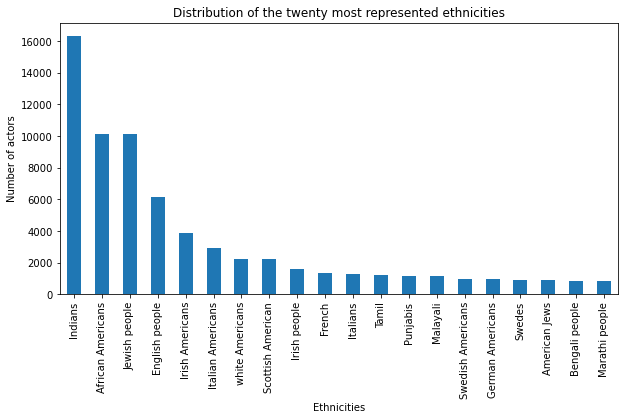

In [24]:
# Ethnicities visualization
plt.figure(figsize=(10,5))
characters.EthnicityName.value_counts()[:20].plot(kind="bar")
plt.xlabel('Ethnicities')
plt.ylabel('Number of actors')
plt.title('Distribution of the twenty most represented ethnicities');

In [25]:
print('The percentage of missing Ethnicity names is :', round(100*characters[['EthnicityName']].isna().sum().values[0]/n_char,2), '%')

The percentage of missing Ethnicity names is : 79.35 %


We only have the names of 20% of the actor ethnicities : this is not enough to base our analysis and to draw conclusions. We thus decided to not use the Ethnicity in our project.

### 1.4.2 Recovering Missing Actor Names  <a id='1.4.2'></a>

In addition, some actors do not have their name and/or date of birth and/or sex specified but the actor freebase ID is present. We can use the actor freebase ID to recover their Wikidata information. This gives us access to the following relevant information about the actor :
- Name
- Sex/Gender
- Date of Birth  
We can therefore replace the missing values in those categories, when the Actor Freebase ID is specified.

In [26]:
print('Number of rows where:\n\tActor is missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and DOB are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tActor, DOB and Gender are missing but actor ID is specified :', len(characters[(characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & ~characters['FreeActorID'].isna())]))
print('\tGender is missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorGender'].isna() & ~characters['FreeActorID'].isna())]))
print('\tDOB and Gender are missing but Actor and actor ID are specified :', len(characters[(~characters['ActorName'].isna() & characters['ActorDOB'].isna() & characters['ActorGender'] & ~characters['FreeActorID'].isna())]))

Number of rows where:
	Actor is missing but actor ID is specified : 413
	Actor and DOB are missing but actor ID is specified : 400
	Actor and Gender are missing but actor ID is specified : 401
	Actor, DOB and Gender are missing but actor ID is specified : 400
	DOB is missing but Actor and actor ID are specified : 104930
	Gender is missing but Actor and actor ID are specified : 44393
	DOB and Gender are missing but Actor and actor ID are specified : 62635


#### Starting with recovery of missing Actor names

For this, we perform the same as in the Ethnicity names recovery.

In [27]:
characters = characters.merge(maps, how="left", left_on="FreeActorID", right_on="free")
characters.drop(columns=["FreeActorID"], inplace=True)
characters.rename(columns={"wiki":"WikiActorID"}, inplace=True)
display(characters.head())

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorName,ActorAgeRelease,FreeMapID,FreeCharID,EthnicityName,free,WikiActorID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,NaN,/m/03wcfv7,Q1873468
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,NaN,/m/0346l4,Q230527
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,African Americans,/m/01vw26l,Q173637
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,NaN,/m/034hyc,Q169963
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,NaN,/m/01y9xg,Q233347


In [28]:
missing_actor = characters[(characters['ActorName'].isna() & ~characters['WikiActorID'].isna())]

In [29]:
map_WikiActorId_Actor = pd.DataFrame(missing_actor.WikiActorID.unique(), columns=["WikiActorID"]).dropna()
map_WikiActorId_Actor["ActorName"] = map_WikiActorId_Actor.WikiActorID.apply(get_wikidata_label)

In [30]:
characters = characters.merge(map_WikiActorId_Actor, how="left", left_on="WikiActorID", right_on="WikiActorID").drop(columns= ["WikiActorID", "WikiActorID"])
characters.drop(columns="free", inplace=True)

In [31]:
characters["ActorName"] = characters.fillna(value={"ActorName_x":""}).ActorName_x + characters.fillna(value={"ActorName_y":""}).ActorName_y
characters.drop(columns=["ActorName_x", "ActorName_y"], inplace=True)

In [32]:
characters.head()

,WikiMovieID,FreeMovieID,ReleaseDate,CharName,ActorDOB,ActorGender,ActorHeight,ActorAgeRelease,FreeMapID,FreeCharID,EthnicityName,ActorName
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,42.0,/m/0bgchxw,/m/0bgcj3x,NaN,Wanda De Jesus
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,27.0,/m/0jys3m,/m/0bgchn4,NaN,Natasha Henstridge
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,32.0,/m/0jys3g,/m/0bgchn_,African Americans,Ice Cube
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,33.0,/m/02vchl6,/m/0bgchnq,NaN,Jason Statham
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,23.0,/m/02vbb3r,/m/0bgchp9,NaN,Clea DuVall


From wikidata actor page,
- sex/gender (P21) is given as : male (Q6581097), female (Q6581072), intersex (Q1097630), transgender female (Q1052281), transgender male (Q2449503).
- date of birth (P569) is given as : Day of the month as a zero-padded decimal number, blank space, Month full name, blank space, Year with century as a decimal number. To recover the date of birth in the same format as the ones in the characters dataset, we must read the date given by wikidata without the blank spaces and then use datetime to format it correctly. See example just below :

In [33]:
wiki_date = '26 December 1949'
no_space = wiki_date.replace(" ", "")
date = datetime.strptime(no_space, '%d''%B''%Y')
formated_date = '{:%Y-%m-%d}'.format(date)
print(formated_date)

1949-12-26


We later decided that we won't use the actors information, so we didn't push further and didn't recover missing DOB or genders.

### Saving augmented characters dataset

Extracting from wikidata takes a few minutes so we can save our final `characters` dataframe in case we want to use that directly in further applications.

In [34]:
os.makedirs('data', exist_ok=True)  
characters.to_csv('data/characters_aug.tsv', sep="\t", index=False)

# 2. Plot Summaries   <a id='2'></a>

The plot summaries are loaded from the file `plot_summaries.txt` and stored into `plot_summaries`dataset. 

In [35]:
plot_summaries = pd.read_csv('data/plot_summaries.txt', sep="\t", header=None,names=["WikiMovieID", "Plot"])
plot_summaries.head(3)

,WikiMovieID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...


## 2.1 Preprocessing  <a id='2.1'></a>

### 2.1.1 Missing plot summaries check  <a id='2.1.1'></a>

In [36]:
print('Number of missing plot summary in the plot_summary dataset: {}'.format(plot_summaries.Plot.isna().sum()))

Number of missing plot summary in the plot_summary dataset: 0


In [37]:
print('Number of missing plot summary when matched to films in movies dataset: {:.2f}%'.format((movies.merge(plot_summaries, how="left", on='WikiMovieID')).Plot.isna().sum()/len(movies)*100))

Number of missing plot summary when matched to films in movies dataset: 48.37%


We can see that we don't have the plot summary for about half of the movies.

### 2.1.2 Cleaning <a id='2.1.2'></a>

We detect the langage used in the plot summary and keep only the ones written in English.

In [38]:
plot_summaries['lang'] = plot_summaries.Plot.progress_apply(detect)

100%|████████████████████████████████████████████████████████████████████████████| 42303/42303 [04:40<00:00, 150.88it/s]


In [39]:
plot_summaries.lang.value_counts()

en    42276
id       14
es        6
de        4
tl        1
sw        1
hi        1
Name: lang, dtype: int64

In [40]:
plot_summaries = plot_summaries.loc[plot_summaries.lang=='en']

### 2.1.3 Tokenization <a id='2.1.3'></a>

Tokenizers are used to divide strings into lists of substrings. For each `Plot` in `plot_summaries` dataset, a list of words and punctuation marks stored in the `words_punc` column, a list of sentences in `sentences` and a list of tokenized sentences `tokens_sentences`. To do so, we use the natural langage processing library `NLTK` (Natural Language Toolkit). "NLTK is a leading platform for building Python programs to work with human language data"[[3]](https://www.nltk.org/).

In [41]:
plot_summaries['words_punc'] = plot_summaries.Plot.progress_apply(lambda x: word_tokenize(x))
plot_summaries['sentences'] = plot_summaries.Plot.progress_apply(lambda x: sent_tokenize(x))
plot_summaries['tokens_sentences'] = plot_summaries['sentences'].progress_apply(lambda sentences: [word_tokenize(sentence) for sentence in sentences])

100%|████████████████████████████████████████████████████████████████████████████| 42276/42276 [01:16<00:00, 550.06it/s]


### 2.1.4 PoS tagging <a id='2.1.4'></a>

Part-of-speech (POS) tagging is a popular Natural Language Processing process which refers to categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context. POS tags from the [*Penn Treebank* tagset](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) are used to describe the lexical terms that we have within our plots.

In [42]:
plot_summaries['POS_tokens'] = plot_summaries['tokens_sentences'].progress_apply(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])

plot_summaries['POS_tokens'].head(3)

100%|█████████████████████████████████████████████████████████████████████████████| 42276/42276 [08:17<00:00, 85.00it/s]


0    [[(Shlykov, NNP), (,, ,), (a, DT), (hard-worki...
1    [[(The, DT), (nation, NN), (of, IN), (Panem, N...
2    [[(Poovalli, NNP), (Induchoodan, NNP), (is, VB...
Name: POS_tokens, dtype: object

### 2.1.5 Lemmatization <a id='2.1.5'></a>

Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. It links words with similar meanings to one word. 

In [43]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

In [44]:
lemmatizer = WordNetLemmatizer()

# Lemmatizing each word with its POS tag, in each sentence
plot_summaries['tokens_sentences_lemmatized'] = plot_summaries['POS_tokens'].progress_apply(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

plot_summaries[['Plot','tokens_sentences_lemmatized']].head(3)

100%|████████████████████████████████████████████████████████████████████████████| 42276/42276 [00:45<00:00, 939.20it/s]


,Plot,tokens_sentences_lemmatized
0,"Shlykov, a hard-working taxi driver and Lyosha...","[[Shlykov, ,, a, hard-working, taxi, driver, a..."
1,The nation of Panem consists of a wealthy Capi...,"[[The, nation, of, Panem, consist, of, a, weal..."
2,Poovalli Induchoodan is sentenced for six yea...,"[[Poovalli, Induchoodan, be, sentence, for, si..."


### 2.1.6 Grouping tokens and removing stop words <a id='2.1.6'></a>

In order to extact interesting information from the words present in the plot summaries, we have to take into account only the meaningful words by removing insignificant ones called stop words.
What we have seen is that the names of the characters in the plot summaries create a lot of unwanted noise which in turn disturbs greatly our results in the topic extraction methods.Therefore, we introduce the [name-dataset](https://pypi.org/project/names-dataset/), which used a Facebook dump to create a first and last name database. From there  we extract the top 2000 first names and use them as stopwords. 

In [45]:
nd = NameDataset()
names = nd.get_top_names(n=2000, country_alpha2="US")
names = names["US"]["M"] + names["US"]["F"]
names = [name.lower() for name in names]

In [46]:
# Words gathered after running the LDA model and collecting the words appearing in more than 4 topics 
stops = ["one", "two", "also", "see", "take", "get", "find", "try", "however", "go", "come", "leave", "become", "make", "back", "run"]
my_stopwords = stopwords.words('english') + names + stops

plot_summaries['tokens'] = plot_summaries['tokens_sentences_lemmatized'].progress_apply(lambda sentences: list(chain.from_iterable(sentences)))

100%|██████████████████████████████████████████████████████████████████████████| 42276/42276 [00:00<00:00, 46429.34it/s]


In [47]:
plot_summaries['tokens'] = plot_summaries['tokens'].progress_apply(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

100%|████████████████████████████████████████████████████████████████████████████| 42276/42276 [04:54<00:00, 143.79it/s]


Another idea, would be to use PoS tagging to remove the all names from the plots instead of using the name-dataset. For example names that are not recognized using the name-dataset would be recognized using proper noun tags (NNP and NNPS).

Saving plot summaries dataframe to access it later without performing again the previous steps:

In [48]:
plot_summaries.to_pickle('data/plot_summaries_aug.pkl')

### 2.1.7 Integration into movies dataset <a id='2.1.7'></a>

In [49]:
plot_summaries = pd.read_pickle('data/plot_summaries_aug.pkl')

The preprocessed plot summaries `plot_summaries` are added to the `movies` dataset according to the Wikipedia movie ID, `WikiMovieID`. 

In [50]:
movies = movies.merge(plot_summaries, how="left", on='WikiMovieID') 

#### Missing values

In part 2.1.1, we see that there is nearly half of the movies that has missing plot summaries. At this stage, we are interested in the plot summaries content so we remove the rows with missing plot summaries in `movies` dataset.

In [51]:
movies = movies.dropna(subset=['Plot'])

In [52]:
print('Length of movies dataset: {}'.format(len(movies)))

Length of movies dataset: 42177


### 2.1.8 Preprocessing results <a id='2.1.8'></a>

In [53]:
movies[['Plot','words_punc','sentences','tokens_sentences','tokens']].head(3)

,Plot,words_punc,sentences,tokens_sentences,tokens
0,"Set in the second half of the 22nd century, th...","[Set, in, the, second, half, of, the, 22nd, ce...","[Set in the second half of the 22nd century, t...","[[Set, in, the, second, half, of, the, 22nd, c...","[set, second, half, century, film, depict, mar..."
3,A series of murders of rich young women throug...,"[A, series, of, murders, of, rich, young, wome...",[A series of murders of rich young women throu...,"[[A, series, of, murders, of, rich, young, wom...","[series, murder, woman, throughout, arizona, d..."
4,"Eva, an upper class housewife, becomes frustra...","[Eva, ,, an, upper, class, housewife, ,, becom...","[Eva, an upper class housewife, becomes frustr...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[upper, class, housewife, becomes, frustrated,..."


In [54]:
print(movies['Plot'][0])

Set in the second half of the 22nd century, the film depicts Mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. The Martian society has become largely matriarchal, with women in most positions of authority. The story concerns a police officer, Melanie Ballard , second in command of a small team alongside Sergeant Jericho  sent to pick up and transport a prisoner named Desolation Williams . Arriving at the remote mining town where Williams is being held, Ballard finds virtually all of the people missing. She learns that the miners had discovered an underground doorway created by an ancient Martian civilization. When the door was opened it released "ghosts," disembodied spirits which possessed the miners. Violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. With their team leader Helena Bradock  murdered, Ballard must fight off the attacking miners, escape th

In [55]:
print(movies['POS_tokens'][0])

[[('Set', 'NN'), ('in', 'IN'), ('the', 'DT'), ('second', 'JJ'), ('half', 'NN'), ('of', 'IN'), ('the', 'DT'), ('22nd', 'JJ'), ('century', 'NN'), (',', ','), ('the', 'DT'), ('film', 'NN'), ('depicts', 'VBZ'), ('Mars', 'NNP'), ('as', 'IN'), ('a', 'DT'), ('planet', 'NN'), ('that', 'WDT'), ('has', 'VBZ'), ('been', 'VBN'), ('84', 'CD'), ('%', 'NN'), ('terraformed', 'VBN'), (',', ','), ('allowing', 'VBG'), ('humans', 'NNS'), ('to', 'TO'), ('walk', 'VB'), ('on', 'IN'), ('the', 'DT'), ('surface', 'NN'), ('without', 'IN'), ('wearing', 'VBG'), ('pressure', 'NN'), ('suits', 'NNS'), ('.', '.')], [('The', 'DT'), ('Martian', 'JJ'), ('society', 'NN'), ('has', 'VBZ'), ('become', 'VBN'), ('largely', 'RB'), ('matriarchal', 'JJ'), (',', ','), ('with', 'IN'), ('women', 'NNS'), ('in', 'IN'), ('most', 'JJS'), ('positions', 'NNS'), ('of', 'IN'), ('authority', 'NN'), ('.', '.')], [('The', 'DT'), ('story', 'NN'), ('concerns', 'VBZ'), ('a', 'DT'), ('police', 'NN'), ('officer', 'NN'), (',', ','), ('Melanie', 'NNP

In [56]:
print(movies['tokens_sentences_lemmatized'][0])

[['Set', 'in', 'the', 'second', 'half', 'of', 'the', '22nd', 'century', ',', 'the', 'film', 'depict', 'Mars', 'as', 'a', 'planet', 'that', 'have', 'be', '84', '%', 'terraformed', ',', 'allow', 'human', 'to', 'walk', 'on', 'the', 'surface', 'without', 'wear', 'pressure', 'suit', '.'], ['The', 'Martian', 'society', 'have', 'become', 'largely', 'matriarchal', ',', 'with', 'woman', 'in', 'most', 'position', 'of', 'authority', '.'], ['The', 'story', 'concern', 'a', 'police', 'officer', ',', 'Melanie', 'Ballard', ',', 'second', 'in', 'command', 'of', 'a', 'small', 'team', 'alongside', 'Sergeant', 'Jericho', 'send', 'to', 'pick', 'up', 'and', 'transport', 'a', 'prisoner', 'name', 'Desolation', 'Williams', '.'], ['Arriving', 'at', 'the', 'remote', 'mining', 'town', 'where', 'Williams', 'be', 'be', 'hold', ',', 'Ballard', 'find', 'virtually', 'all', 'of', 'the', 'people', 'miss', '.'], ['She', 'learn', 'that', 'the', 'miner', 'have', 'discover', 'an', 'underground', 'doorway', 'create', 'by', '

In [57]:
print(movies['tokens'][0])

['set', 'second', 'half', 'century', 'film', 'depict', 'mars', 'planet', 'terraformed', 'allow', 'human', 'walk', 'surface', 'without', 'wear', 'pressure', 'suit', 'martian', 'society', 'largely', 'matriarchal', 'woman', 'position', 'authority', 'story', 'concern', 'police', 'officer', 'ballard', 'second', 'command', 'small', 'team', 'alongside', 'sergeant', 'jericho', 'send', 'pick', 'transport', 'prisoner', 'name', 'desolation', 'arriving', 'remote', 'mining', 'town', 'hold', 'ballard', 'virtually', 'people', 'miss', 'learn', 'miner', 'discover', 'underground', 'doorway', 'create', 'ancient', 'martian', 'civilization', 'door', 'open', 'release', 'ghost', 'disembody', 'spirit', 'possess', 'miner', 'violence', 'ensues', 'possessed', 'miner', 'commit', 'horrific', 'act', 'death', 'destruction', 'well', 'team', 'leader', 'bradock', 'murder', 'ballard', 'must', 'fight', 'attack', 'miner', 'escape', 'town', 'destroy', 'ghost', 'possible', 'unfortunately', 'intention', 'complicate', 'fact',

## 2.2 Importing Metascore  <a id='2.2'></a>

When considering film rating, we can think about using the IMDb database. In particular, it provides the variable `averageRating` which is the weighted average of all the individual user ratings. However, IMDb user opinions can be given whenever the user wants. So, the ratings of IMDb do not match with the release date of the movie. It only works for analyzing the current opinions, as very recent reviews and can be written for an old film. 

In order to have an insigth into the movie impression at a time closer to the release date, we can consider metascore. [Metascore](https://github.com/miazhx/metacritic) is a weighted average of reviews from top published critic reviews for a given movie, and thus does not include any votes or comments from our users.


#### Metacritic dataset loading

We use a dataset which brings together the film title, release date, metascore and other scores. We load it and add the `metascore` information into the `movie` dataset.

In [58]:
metacritic_url = "https://raw.githubusercontent.com/miazhx/metacritic/master/data/metacritic_movies.csv"

metacritic = pd.read_csv(metacritic_url)

In [59]:
metacritic.head()

,movie_title,release_date,genre,meta_mixed,meta_negative,meta_positive,metascore,user_mixed,user_negative,user_positive,userscore
0,Anatomy of a Murder,1-Jul-59,"Drama,Mystery,Thriller,Crime",0,0,15,95,0,0,3,tbd
1,Bringing Up Baby,18-Feb-38,"Comedy,Romance,Family",0,1,16,91,1,0,2,tbd
2,After Life,12-May-99,"Drama,Fantasy",0,0,19,91,0,2,1,tbd
3,Gavagai,3-Aug-18,Drama,1,0,6,91,0,1,2,tbd
4,The Hustler,25-Sep-61,"Drama,Sport",1,0,17,90,0,0,3,tbd


In [60]:
print('Number of rows in metacrtic dataset: {}'.format(len(metacritic)))

Number of rows in metacrtic dataset: 9121


#### Missing value check

In [61]:
print('Number of missing metascore in metacritic dataset: {}'.format(metacritic['metascore'].isna().sum()))

Number of missing metascore in metacritic dataset: 0


In [62]:
print('Number of missing title in metacritic dataset: {}'.format(metacritic['movie_title'].isna().sum()))

Number of missing title in metacritic dataset: 0


In [63]:
print('There are {} metascores for {} movies with plot summary available.'.format(len(metacritic),len(movies)))

There are 9121 metascores for 42177 movies with plot summary available.


#### Integration of metascores to `movies` dataset

In `metacritic` data set we are only interested in ratings for now. For each movie, we want to add the corresponding metascore if available. Unfortunately the `metacritic` data set does not have WikiID or unique identifier for the movie. Also, titles are not unique so we cannot match the two datasets according to this feature. One option is to match the data according to the title and the release date. In `metacritic` the release year is given by only 2 digits. So the data are matched in an non optimal way by comparing the title and the two last digits of the year.

In [64]:
#Get informative subdataset, convert release date to datetime
metacritic_score = metacritic[['movie_title','metascore','release_date']].rename(columns = {'movie_title':'Title'})
metacritic_score['release_date_'] = pd.to_datetime(metacritic_score['release_date'], format='%d-%b-%y')

In [65]:
#Get the two last digits, trying to deal with the misconvertion of years due to the initial format with only two digits for the year
metacritic_score['year_last_digits'] = metacritic_score['release_date_'].apply( lambda x: int(x.year-100) if (x.year >2022) else int(x.year))
metacritic_score['year_last_digits'] = metacritic_score['year_last_digits'].apply( lambda x: x-2000 if (x > 1999) else x-1900)

In [66]:
#Get the two last digits of the year in movies dataset
movies['ReleaseDate_'] = pd.to_datetime(movies['ReleaseDate'], format="%Y-%m-%d", errors="coerce").fillna(pd.to_datetime(movies['ReleaseDate'], format="%Y", errors="coerce"))
movies['year_last_digits'] = movies['ReleaseDate_'].apply( lambda x: int(str(x.year)[2:4]) if ( pd.notnull(x) ) else x)
movies[['ReleaseDate_','year_last_digits']].head()

,ReleaseDate_,year_last_digits
0,2001-08-24,1
3,1987-01-01,87
4,1983-01-01,83
6,2002-01-01,2
12,1997-04-04,97


In [67]:
metacritic_score.head()

,Title,metascore,release_date,release_date_,year_last_digits
0,Anatomy of a Murder,95,1-Jul-59,2059-07-01,59
1,Bringing Up Baby,91,18-Feb-38,2038-02-18,38
2,After Life,91,12-May-99,1999-05-12,99
3,Gavagai,91,3-Aug-18,2018-08-03,18
4,The Hustler,90,25-Sep-61,2061-09-25,61


Adding metascores to the `movies` dataset by merging on `Tilte`and release year.

In [68]:
movies = movies.merge(metacritic_score[['Title','metascore','year_last_digits']], how="left", on=['Title','year_last_digits'] ) 

In [69]:
movies.head()

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Plot,lang,words_punc,sentences,tokens_sentences,POS_tokens,tokens_sentences_lemmatized,tokens,ReleaseDate_,year_last_digits,metascore
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",en,"[Set, in, the, second, half, of, the, 22nd, ce...","[Set in the second half of the 22nd century, t...","[[Set, in, the, second, half, of, the, 22nd, c...","[[(Set, NN), (in, IN), (the, DT), (second, JJ)...","[[Set, in, the, second, half, of, the, 22nd, c...","[set, second, half, century, film, depict, mar...",2001-08-24,1,35.0
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,en,"[A, series, of, murders, of, rich, young, wome...",[A series of murders of rich young women throu...,"[[A, series, of, murders, of, rich, young, wom...","[[(A, DT), (series, NN), (of, IN), (murders, N...","[[A, series, of, murder, of, rich, young, woma...","[series, murder, woman, throughout, arizona, d...",1987-01-01,87,NaN
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",en,"[Eva, ,, an, upper, class, housewife, ,, becom...","[Eva, an upper class housewife, becomes frustr...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[[(Eva, NNP), (,, ,), (an, DT), (upper, JJ), (...","[[Eva, ,, an, upper, class, housewife, ,, beco...","[upper, class, housewife, becomes, frustrated,...",1983-01-01,83,NaN
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",en,"[Every, hundred, years, ,, the, evil, Morgana,...","[Every hundred years, the evil Morgana return...","[[Every, hundred, years, ,, the, evil, Morgana...","[[(Every, DT), (hundred, CD), (years, NNS), (,...","[[Every, hundred, year, ,, the, evil, Morgana,...","[every, hundred, year, evil, morgana, return, ...",2002-01-01,2,NaN
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",en,"[Adam, ,, a, San, Francisco-based, artist, who...","[Adam, a San Francisco-based artist who works ...","[[Adam, ,, a, San, Francisco-based, artist, wh...","[[(Adam, NNP), (,, ,), (a, DT), (San, NNP), (F...","[[Adam, ,, a, San, Francisco-based, artist, wh...","[artist, work, cab, driver, side, hard, time, ...",1997-04-04,97,NaN


In [70]:
print('We were able to retreive {} metascores.'.format(len(movies)-movies.metascore.isna().sum()))

We were able to retreive 3694 metascores.


In [71]:
print("Missing metascores in movies dataset: {:.2f}%".format(movies['metascore'].isna().sum()/len(movies)*100))

Missing metascores in movies dataset: 91.24%


With 9121 metascores initially, we could have hoped to have about 20% of our movies with plot augmented with metascores. In the end, we only managed to match half of these metascores which represents about 10% of the movies with plot summaries available.  
This result is not entirely satisfying because a lot of metascores are missing. If we want to increase this percentage, we should fetch data from the web (IMDb website has metascores), we will see this in Milestone 3.

## 2.3 Initial analysis  <a id='2.3'></a>

### 2.3.1 Plot structure <a id='2.3.1'></a>

Here, for each plot summary, we investigate the number of sentences, number of words, numbers of the different punctuation marks.

We add new columns to the `movies` dataframe by counting, in each plot summary, the number of sentences, words and punctuation marks.

In [72]:
movies['plot_num_sentences'] = movies.sentences.apply( lambda x: len(x))
movies['plot_num_words'] =  movies.Plot.apply( lambda x: len(RegexpTokenizer(r'\w+').tokenize(x)))
movies['plot_num_dot'] = movies.words_punc.apply( lambda x: list(x).count('.'))
movies['plot_num_coma'] = movies.words_punc.apply( lambda x: x.count(','))
movies['plot_num_interrogation'] = movies.words_punc.apply( lambda x: x.count('?'))
movies['plot_num_exclamation'] = movies.words_punc.apply( lambda x: x.count('!'))
movies['plot_num_percentage'] = movies.words_punc.apply( lambda x: x.count('%'))
movies['plot_num_semicolon'] = movies.words_punc.apply( lambda x: x.count(';'))
movies['plot_num_colon'] = movies.words_punc.apply( lambda x: x.count(':'))

movies[['plot_num_sentences','plot_num_words','plot_num_dot','plot_num_coma','plot_num_interrogation',\
        'plot_num_exclamation','plot_num_percentage','plot_num_semicolon','plot_num_colon']].head()

,plot_num_sentences,plot_num_words,plot_num_dot,plot_num_coma,plot_num_interrogation,plot_num_exclamation,plot_num_percentage,plot_num_semicolon,plot_num_colon
0,15,357,15,22,0,0,1,0,0
1,36,600,36,23,0,0,0,1,0
2,24,441,24,30,0,0,0,0,0
3,7,165,7,8,0,0,0,0,0
4,9,235,9,15,0,0,0,0,0


#### 2.3.1.1 Statistics

In [73]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
movies[['plot_num_sentences','plot_num_words','plot_num_dot','plot_num_coma','plot_num_interrogation',
        'plot_num_exclamation','plot_num_percentage','plot_num_semicolon','plot_num_colon']].describe()

,plot_num_sentences,plot_num_words,plot_num_dot,plot_num_coma,plot_num_interrogation,plot_num_exclamation,plot_num_percentage,plot_num_semicolon,plot_num_colon
count,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000
mean,15.689,315.989,15.454,18.626,0.079,0.089,0.009,0.415,0.304
std,16.596,323.369,16.504,20.719,0.449,0.560,0.284,1.202,0.930
min,1.000,14.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.000,89.000,4.000,4.000,0.000,0.000,0.000,0.000,0.000
50%,9.000,190.000,9.000,11.000,0.000,0.000,0.000,0.000,0.000
75%,23.000,460.000,23.000,27.000,0.000,0.000,0.000,0.000,0.000
max,344.000,5016.000,333.000,307.000,30.000,27.000,52.000,65.000,48.000


#### 2.3.1.2 Visualizations

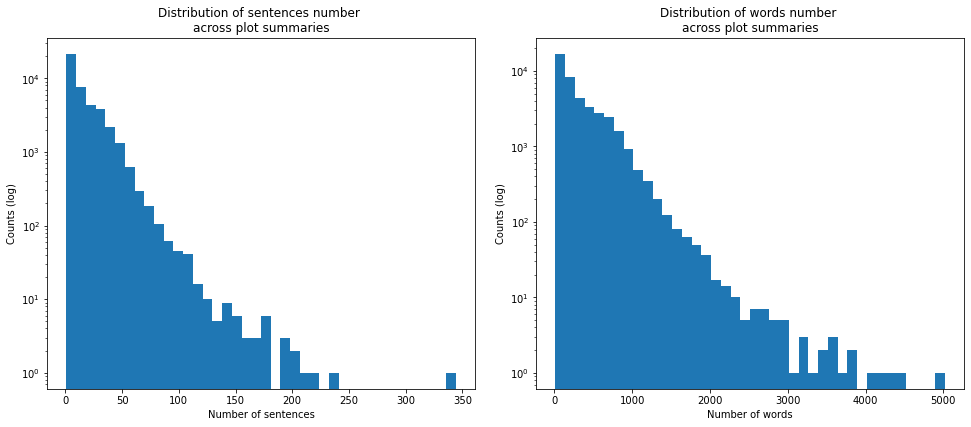

In [74]:
fig, axs = plt.subplots(1, 2, figsize=(14,6))
fig.tight_layout(pad=3)
axs[0].hist(movies.plot_num_sentences,bins=40,log=True)
axs[0].set_title('Distribution of sentences number \nacross plot summaries')
axs[0].set_xlabel('Number of sentences')
axs[0].set_ylabel('Counts (log)')

axs[1].hist(movies.plot_num_words,bins=40,log=True)
axs[1].set_title('Distribution of words number \nacross plot summaries')
axs[1].set_xlabel('Number of words')
axs[1].set_ylabel('Counts (log)')

plt.show()

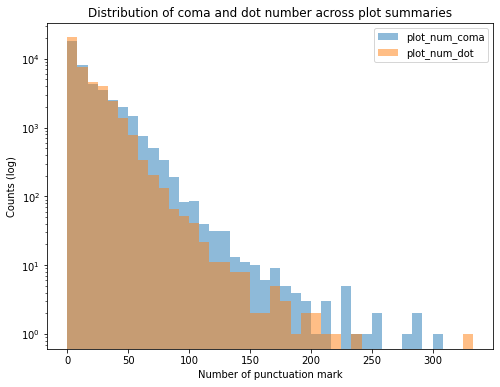

In [75]:
punctuation1 = movies[['plot_num_coma','plot_num_dot']]
punctuation1.plot.hist(bins=40, log=True, alpha=0.5, figsize = (8,6))
plt.title('Distribution of coma and dot number across plot summaries')
plt.xlabel('Number of punctuation mark')
plt.ylabel('Counts (log)')
plt.show()

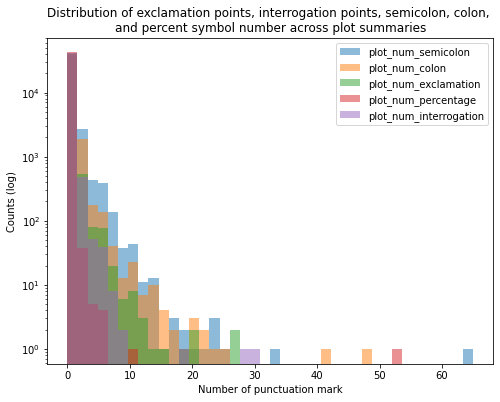

In [76]:
punctuation2 = movies[['plot_num_semicolon','plot_num_colon','plot_num_exclamation','plot_num_percentage','plot_num_interrogation']]
punctuation2.plot.hist(bins=40, log=True, alpha=0.5, figsize = (8,6))
plt.title('Distribution of exclamation points, interrogation points, semicolon, colon, \nand percent symbol number across plot summaries')
plt.xlabel('Number of punctuation mark')
plt.ylabel('Counts (log)')
plt.show()

We observe in general that punctuation distributions follow a heavy-tailed distribution.

### 2.3.2 Most common tokens in plot summaries <a id='2.3.2'></a>

In [77]:
"""
Find the n most common elment of a list
Inputs: 
     n[int]: number of most common elements
     List of interest
Ouptuts:
    List of n tuples liking the element and its number of occurence(s)
"""
def most_frequent(List,n):
    occurence_count = Counter(List)
    return occurence_count.most_common(n)

In each plot, the ten most used tokens are represented in the dataframe as a pair of token and its occurence.

In [78]:
movies['plot_top_ten_tokens'] = movies.tokens.apply( lambda x: most_frequent(x,10))

movies['plot_top_ten_tokens'].head() 

0    [(ballard, 8), (miner, 5), (team, 4), (human, ...
1    [(gun, 4), (quarry, 4), (sound, 3), (echo, 3),...
2    [(scene, 4), (look, 3), (money, 3), (romantic,...
3    [(year, 3), (evil, 3), (hundred, 2), (morgana,...
4    [(break, 4), (relationship, 2), (woman, 2), (m...
Name: plot_top_ten_tokens, dtype: object

For the analysis of the most used token accross genre, we will remove the occurence.

In [79]:
"""
Transform a list provided by the function "most_frequent"
Inputs: 
     List of tuples (element, occurence)
Ouptuts:
    List of element without occurence
"""
def remove_nb_usage(list_tokens):
  # to remove the number of occurence of the 10 most used tokens
    clean_tokens = []
    for pair in list_tokens:
        clean_tokens.append(pair[0])
    return clean_tokens

In [80]:
movies['clean_top_ten_tokens'] = movies['plot_top_ten_tokens'].apply(remove_nb_usage)

In [81]:
movies['clean_top_ten_tokens'].head(3)

0    [ballard, miner, team, human, martian, sergean...
1    [gun, quarry, sound, echo, head, away, abandon...
2    [scene, look, money, romantic, gigolo, slowly,...
Name: clean_top_ten_tokens, dtype: object

### 2.3.3 Movie genres clustering <a id='2.3.3'></a>

In the future, we would like to match movie genres with most used tokens, to see if some tokens are repeated. This analysis won't be performed in Milestone3, but could be a good lead for Milestone3. For now, we begin with a raw clustering of movie genres.

In the movies dataframe, `Genres` is usually a list with multiple genres or subgenres. First, we extract each individual genres. 

In [82]:
"""
Get each element from lists inside of a pandas Series
"""
def to_1D(series):
    return pd.Series([x for list_ in series for x in list_])

In [83]:
pd.set_option('display.max_rows', None)
individual_genres = to_1D(movies['Genres'])
print(individual_genres.value_counts().index.tolist())

['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'World cinema', 'Crime Fiction', 'Horror', 'Black-and-white', 'Indie', 'Action/Adventure', 'Adventure', 'Family Film', 'Short Film', 'Romantic drama', 'Animation', 'Musical', 'Science Fiction', 'Mystery', 'Romantic comedy', 'Fantasy', 'Comedy film', 'Crime Thriller', 'War film', 'Period piece', 'Japanese Movies', 'Comedy-drama', 'Film adaptation', 'Documentary', 'Silent film', 'Psychological thriller', 'Bollywood', 'Western', 'Chinese Movies', 'Black comedy', 'Teen', 'LGBT', 'Parody', 'Family Drama', "Children's/Family", 'Coming of age', 'Martial Arts Film', 'Cult', 'Sports', 'Television movie', 'Slasher', 'Suspense', 'Biographical film', 'Biography', 'Supernatural', 'Satire', 'Political drama', 'Film noir', 'Slapstick', 'Melodrama', "Children's", 'Action Thrillers', 'Crime Drama', 'B-movie', 'Costume drama', 'Biopic [feature]', 'History', 'Music', 'Art film', 'Ensemble Film', 'Creature Film', 'Spy', 'Gangster Film', 'Buddy film

In [84]:
print('There are', len(individual_genres.value_counts()), 'unique genres.')

There are 363 unique genres.


For visualization purpose, we won't use the 363 different genres for now.  

For now, we will create bigger theme/genre clusters.   Disclaimer : This is a first, raw extraction of bigger movie theme/genre, to have some insights about movie genres. However his grouping is not exhaustive and as not complete, may lead to bias in interpretation.

To do so, we create 24 big clusters. A first cluster list will contain keywords that are present in the genre name. Then, we search if a genre is present in a cluster and add it to a final cluster list, that will contain the actual genre names.

In [85]:
# lists containing cluster keywords 
comedy = ['comedy', 'comedies', 'humour', 'satire', 'parody', 'bloopers',\
          'gross', 'slapstick']
drama = ['drama', 'tragedy']
horror = ['horror', 'haunted', 'demonic', 'escape', 'splatter']
romance = ['romance', 'romantic']
criminal = ['thriller', 'crime', 'detective', 'gangset', 'criminal', 'giallo',\
            'heist', 'neo-noir', 'film noir'] 
action_adventure = ['action', 'adventure', 'war', 'spy', 'ninja', 'martial',\
                    'tokusatsu', 'outlaw', 'combat', 'buddy', 'biker', 'epic',\
                     'swashbuckler'] 
entertainment_hobby = ['family', 'children', 'sport', 'baseball', 'dance',\
                       'holiday', 'christmas', 'party', 'hip hop', 'beach']
fiction = ['fiction', 'fictional', 'dystopia', 'future noir']
erotism = ['erotic','pornography', 'erotica', 'adult', 'porn', 'homoeroticism',\
           'pinku']
sci_fi = ['science fiction', 'sci-fi', 'alien', 'supernatural', 'time travel',\
          'space opera']
animation = ['animation', 'anime', 'animated']
musical = ['musical', 'music', 'concert', 'operetta', 'film-opera']
fantasy = ['fantasy', 'fantasies', 'superhero', 'werewolf', 'sorcery', 'fairy',\
           'vampire', 'creature', 'zombie', 'monster', 'sword and sandal']
western = ['western', 'cowboy']
biography = ['biography', 'biographical']
queer = ['gay', 'lgbt', 'queer']
apocalypse = ['disaster', 'apocalyptic']
historical = ['history', 'historical', 'cold war', 'gulf war', 'world war',\
              'empire', 'gladiators', 'inventions']
society = ['social', 'prison', 'gender', 'media', 'society', 'disabilities',\
           'relationships', 'journalism', 'education', ]
religion = ['christian', 'religious', 'hagiography']
engaged = ['anti-war', 'feminist', 'political']
ethnic = ['chinese', 'filipino', 'samurai', 'japanese', 'bollywood',\
          'latino', 'malayalam', 'world cinema', 'bengali', 'tollywood'\
          'czechoslovak', 'northern', 'early black', 'blaxploitation']
low_budget = ['b-', 'c-', 'z movie', 'indie', 'sexploitation']
_ism = ['surrealism', 'expressionism', 'neorealism', 'existentialism',\
        'realism', 'avant-garde', 'absurdism', 'kafkaesque', 'experimental']

In [86]:
# lists that will contain actual genre names
group_comedy, numbers_comedy = [], []
group_drama, numbers_drama = [], []
group_horror, numbers_horror = [], []
group_romance, numbers_romance = [], []
group_criminal, numbers_criminal = [], []
group_action_adv, numbers_action_adv = [], []
group_entert_hobb, numbers_entert_hobb = [], []
group_fiction, numbers_fiction = [], []
group_erotism, numbers_erotism = [], []
group_scifi, numbers_scifi = [], []
group_animation, numbers_animation = [], []
group_musical, numbers_musical = [], []
group_fantasy, numbers_fantasy = [], []
group_western, numbers_western = [], []
group_biography, numbers_biography = [], []
group_queer, numbers_queer = [], []
group_apocalypse, numbers_apocalypse = [], []
group_history, numbers_hystory = [], []
group_society, numbers_society = [], []
group_religion, numbers_religion = [], []
group_engaged, numbers_engaged = [], []
group_world, numbers_world = [], []
group_lowbud, numbers_lowbud = [], []
group_ism, numbers_ism = [], []

In [87]:
"""
Appends to a list movie genres that belongs to a same cluster.
"""
def find_cluster(cluster, genre, count, group, numbers):
    for keyword in cluster :
        if keyword in genre:
            group.append(genre)
            numbers.append(count)
            break

In [88]:
indiv_genres = [x.lower() for x in individual_genres.value_counts().index.to_numpy()]
indiv_counts = [x for x in individual_genres.value_counts().values]
for g, count in zip(indiv_genres, indiv_counts):
    find_cluster(comedy, g, count, group_comedy, numbers_comedy)
    find_cluster(drama, g, count, group_drama, numbers_drama)
    find_cluster(horror, g, count, group_horror, numbers_horror)
    find_cluster(romance, g, count, group_romance, numbers_romance)
    find_cluster(criminal, g, count, group_criminal, numbers_criminal)
    find_cluster(action_adventure, g, count, group_action_adv, numbers_action_adv)
    find_cluster(entertainment_hobby, g, count, group_entert_hobb, numbers_entert_hobb)
    find_cluster(fiction, g, count, group_fiction, numbers_fiction)
    find_cluster(erotism, g, count, group_erotism, numbers_erotism)
    find_cluster(sci_fi, g, count, group_scifi, numbers_scifi)
    find_cluster(animation, g, count, group_animation, numbers_animation)
    find_cluster(musical, g, count, group_musical, numbers_musical)
    find_cluster(fantasy, g, count, group_fantasy, numbers_fantasy)
    find_cluster(western, g, count, group_western, numbers_western)
    find_cluster(biography, g, count, group_biography, numbers_biography)
    find_cluster(queer, g, count, group_queer, numbers_queer)
    find_cluster(apocalypse, g, count, group_apocalypse, numbers_apocalypse)
    find_cluster(historical, g, count, group_history, numbers_hystory)
    find_cluster(society, g, count, group_society, numbers_society)
    find_cluster(religion, g, count, group_religion, numbers_religion)
    find_cluster(engaged, g, count, group_engaged, numbers_engaged)
    find_cluster(ethnic, g, count, group_world, numbers_world)
    find_cluster(low_budget, g, count, group_lowbud, numbers_lowbud)
    find_cluster(_ism, g, count, group_ism, numbers_ism)

In [89]:
"""
Create bar plots for each cluster of movie genres.
"""
def plot_clusters(ix, iy, group, counts, title, c):
    axs[ix, iy].bar(group, counts, log=True, color=c)
    axs[ix, iy].tick_params(labelrotation=90)
    axs[ix, iy].set_ylabel('counts (log)')
    axs[ix, iy].set_title(title+' movie genre cluster')

We are now plotting each cluster to see the distribution of its individual subgenres.

In [90]:
cluster_names = ['Comedy', 'Drama', 'Horror', 'Romance', 'Criminal/Thriller', 'Action/Adventure', 'Entertainment/Hobby', 'Fiction',\
                 'Erotism','Science Fiction', 'Animation', 'Musical', 'Fantasy', 'Western', 'Biography', 'LGBTQ+', 'Apocalyptic',\
                 'Historical', 'Societal','Religious', 'Engaged', 'Ethnic', 'Low budget', 'Current, movement']
colors = ['lightcoral', 'forestgreen', 'coral', 'gold', 'indianred', 'silver', 'orange', 'navy', 'yellowgreen',\
          'bisque', 'mediumorchid', 'limegreen', 'darkgoldenrod', 'turquoise', 'deeppink', 'lightblue',\
          'rosybrown','steelblue', 'pink', 'brown', 'khaki', 'gray', 'violet', 'palegreen'] 

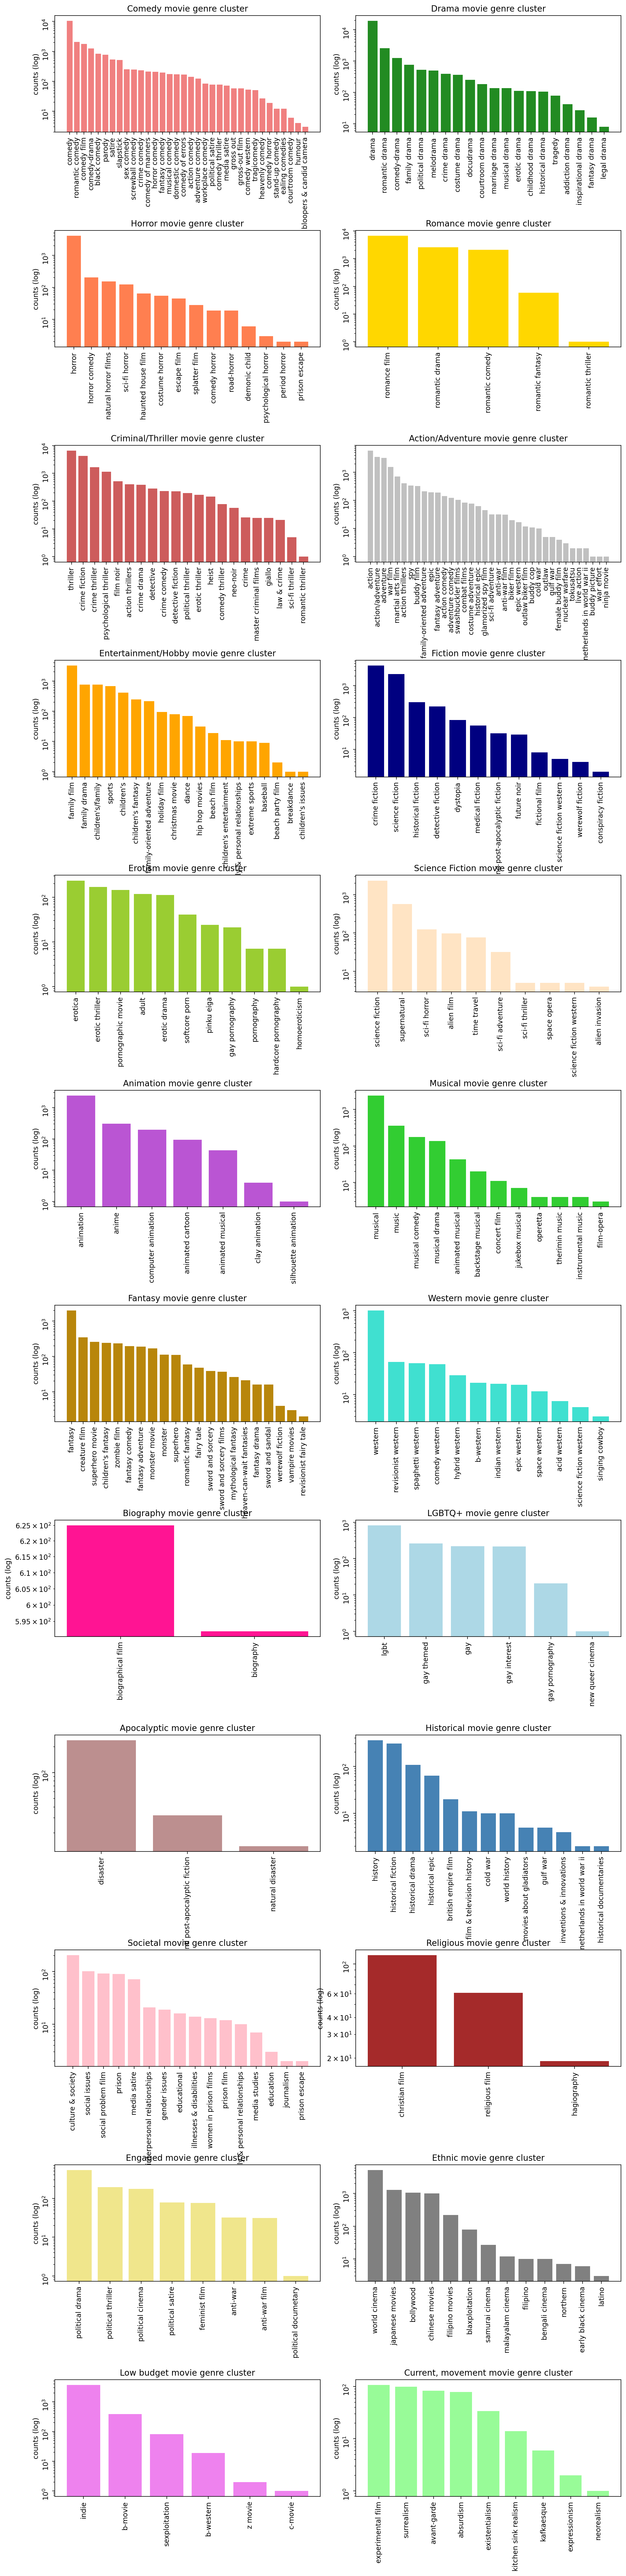

In [91]:
fig, axs = plt.subplots(12, 2, figsize = (12,50), dpi=200)
fig.tight_layout(h_pad=12, w_pad=2)

plot_clusters(0,0, group_comedy, numbers_comedy, cluster_names[0], colors[0])
plot_clusters(0,1, group_drama, numbers_drama, cluster_names[1], colors[1])
plot_clusters(1,0, group_horror, numbers_horror, cluster_names[2], colors[2])
plot_clusters(1,1, group_romance, numbers_romance, cluster_names[3], colors[3])
plot_clusters(2,0, group_criminal, numbers_criminal, cluster_names[4], colors[4])
plot_clusters(2,1, group_action_adv, numbers_action_adv, cluster_names[5], colors[5])
plot_clusters(3,0, group_entert_hobb, numbers_entert_hobb, cluster_names[6], colors[6])
plot_clusters(3,1, group_fiction, numbers_fiction, cluster_names[7], colors[7])
plot_clusters(4,0, group_erotism, numbers_erotism, cluster_names[8], colors[8])
plot_clusters(4,1, group_scifi, numbers_scifi, cluster_names[9], colors[9])
plot_clusters(5,0, group_animation, numbers_animation, cluster_names[10], colors[10])
plot_clusters(5,1, group_musical, numbers_musical, cluster_names[11], colors[11])
plot_clusters(6,0, group_fantasy, numbers_fantasy, cluster_names[12], colors[12])
plot_clusters(6,1, group_western, numbers_western, cluster_names[13], colors[13])
plot_clusters(7,0, group_biography, numbers_biography, cluster_names[14], colors[14])
plot_clusters(7,1, group_queer, numbers_queer, cluster_names[15], colors[15])
plot_clusters(8,0, group_apocalypse, numbers_apocalypse, cluster_names[16], colors[16])
plot_clusters(8,1, group_history, numbers_hystory, cluster_names[17], colors[17])
plot_clusters(9,0, group_society, numbers_society, cluster_names[18], colors[18])
plot_clusters(9,1, group_religion, numbers_religion, cluster_names[19], colors[19])
plot_clusters(10,0, group_engaged, numbers_engaged, cluster_names[20], colors[20])
plot_clusters(10,1, group_world, numbers_world, cluster_names[21], colors[21])
plot_clusters(11,0, group_lowbud, numbers_lowbud, cluster_names[22], colors[22])
plot_clusters(11,1, group_ism, numbers_ism, cluster_names[23], colors[23])

plt.show()

Now we visualized which genres were present in each cluster, we visualize the distribution of these clusters across movies. Again, these clusters may not be fully representative of the entire movie set. But it is sufficient for a broad analysis.

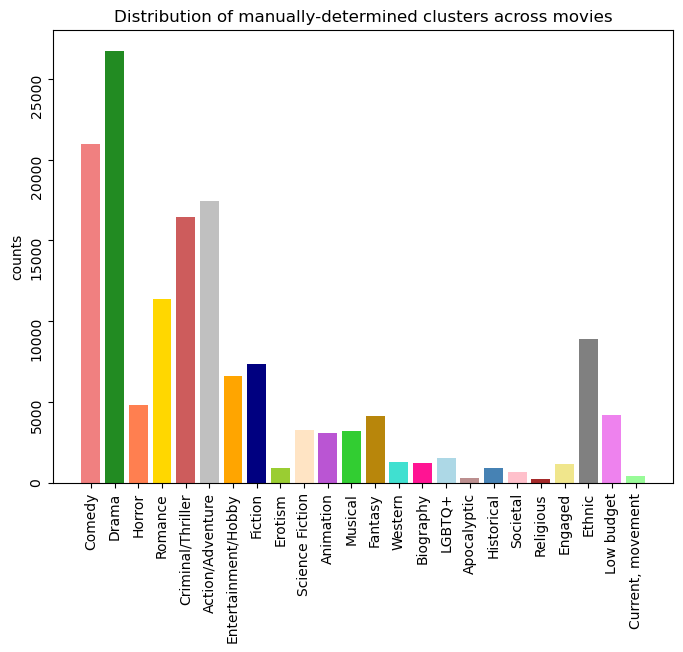

In [92]:
plt.figure(figsize=(8,6), dpi=100)
cluster_counts = [sum(numbers_comedy), sum(numbers_drama), sum(numbers_horror), sum(numbers_romance), sum(numbers_criminal),\
                  sum(numbers_action_adv), sum(numbers_entert_hobb), sum(numbers_fiction), sum(numbers_erotism), sum(numbers_scifi),\
                  sum(numbers_animation), sum(numbers_musical), sum(numbers_fantasy), sum(numbers_western), sum(numbers_biography),\
                  sum(numbers_queer), sum(numbers_apocalypse), sum(numbers_hystory), sum(numbers_society), sum(numbers_religion),\
                  sum(numbers_engaged), sum(numbers_world), sum(numbers_lowbud), sum(numbers_ism)]
plt.bar(cluster_names, cluster_counts, color=colors) 
plt.tick_params(labelrotation=90)
plt.ylabel('counts')
plt.title('Distribution of manually-determined clusters across movies')
plt.show()

### 2.3.4 Words polarity <a id='2.3.4'></a>

Here we want to create 2 additional columns in `movies` indicating the count of positive and negative terms present in plot summaries. We make an intersection between each plot words list and each list of positive or negative words. The positive and negative lists of words are created from online text documents using the get function, the missing values and the title are filtered to get the relevant terms only. 

In [93]:
# Count of the different negative and positive words
positive_txt = requests.get('https://ptrckprry.com/course/ssd/data/positive-words.txt').text
negative_txt = requests.get('https://ptrckprry.com/course/ssd/data/negative-words.txt').text

def parse_str(s):
    return list(filter(lambda x:x[0]!=';', list(filter(None, s.split("\n")))))

In [94]:
movies['plot_num_positive']= movies.Plot.apply(lambda x : len(set(parse_str(positive_txt)) & set(RegexpTokenizer(r'\w+').tokenize(x.lower()))))
movies['plot_num_negative']= movies.Plot.apply(lambda x : len(set(parse_str(negative_txt)) & set(RegexpTokenizer(r'\w+').tokenize(x.lower()))))

movies[['plot_num_positive','plot_num_negative']].head(3)

,plot_num_positive,plot_num_negative
0,2,18
1,15,22
2,11,14


#### Visualization

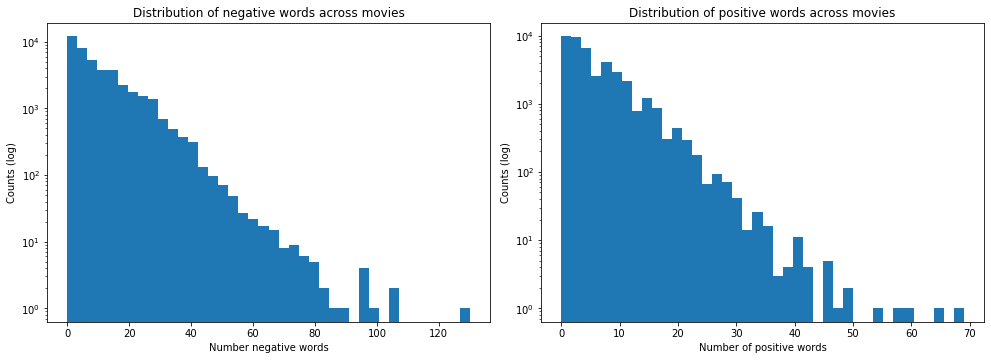

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
fig.tight_layout(pad=2)
axs[0].hist(movies.plot_num_negative,bins=40,log=True)
axs[0].set_title('Distribution of negative words across movies')
axs[0].set_xlabel('Number negative words')
axs[0].set_ylabel('Counts (log)')

axs[1].hist(movies.plot_num_positive,bins=40,log=True)
axs[1].set_title('Distribution of positive words across movies')
axs[1].set_xlabel('Number of positive words')
axs[1].set_ylabel('Counts (log)')

plt.show()

We observe that most movies use mainly a relatively small number of positive and negative words. Indeed, the distribution is the highest between 0 and 10 words. The main part use 40 or less positive words and 80 or less negative words.  

A deeper anaysis could be done across genres or countries instead of movies. We will let this for Milestone3.

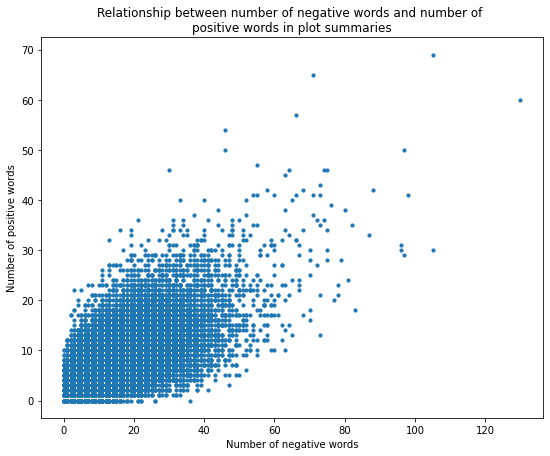

In [96]:
plt.figure(figsize=(9,7))
plt.scatter(movies.plot_num_negative, movies.plot_num_positive, s=10)
plt.title('Relationship between number of negative words and number of \npositive words in plot summaries')
plt.xlabel('Number of negative words')
plt.ylabel('Number of positive words')
plt.show()

We observe an approximative linear trend : few negative words used correspond to few positive words used, and a lot of negative words correspond to a lot of positive words. However, most movies use a small/an average number of both positive and negative words.  

Again, this analysis will be further explored with genres and countries in Milestone3.

In [97]:
print('Linear association between count of negative words and count of positive words across plot summaries:')
print(stats.pearsonr(movies.plot_num_negative, movies.plot_num_positive))

Linear association between count of negative words and count of positive words across plot summaries:
(0.7242776650273484, 0.0)


Since we have a Pearson's r value of 0.72, there is a relatively strong significant linear correlation between number of negative and positive words.

### 2.3.5 Metascore preliminary visualization <a id='2.3.5'></a>

#### Statistics

In [98]:
movies.metascore.describe()

count   3694.000
mean      55.814
std       18.232
min        9.000
25%       43.000
50%       56.000
75%       69.000
max      100.000
Name: metascore, dtype: float64

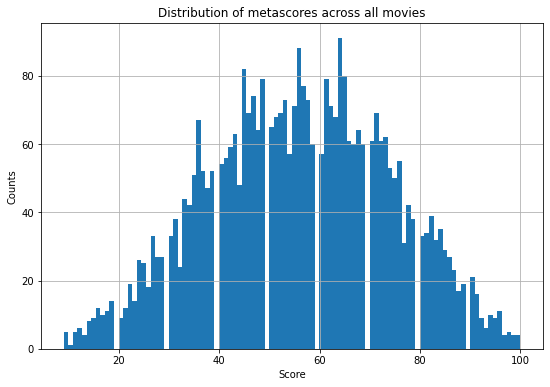

In [99]:
plt.figure(figsize=(9,6))
movies.metascore.hist(bins=100)
plt.title('Distribution of metascores across all movies')
plt.xlabel('Score')
plt.ylabel('Counts')
plt.show()

The metascores distribution looks like a Gaussian distribution. We see some score are never given to movies, at regular intervals!

### 2.3.6 WordCloud <a id='2.3.6'></a>

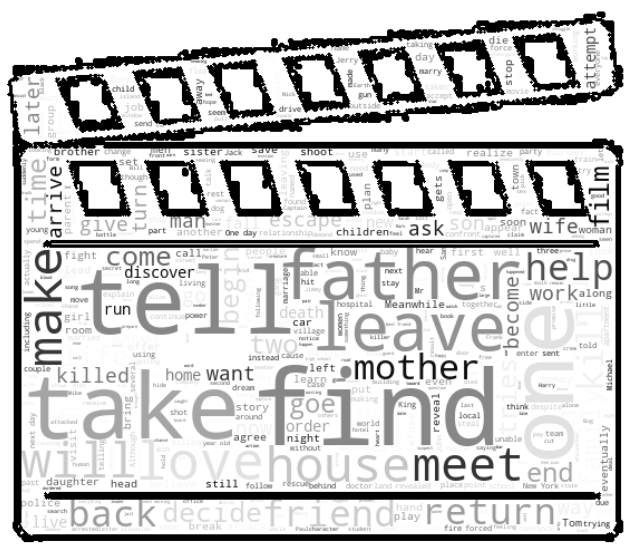

In [100]:
docs = plot_summaries.Plot.tolist()
d = " ".join(docs)

clap = np.array(Image.open("data/masks_wordclouds/clap.png"))

# Create a word cloud image
wc = WordCloud(background_color="white", max_words=500, mask=clap,
               stopwords=STOPWORDS, contour_width=3, contour_color='black', colormap="Greys")

# Generate a wordcloud
wc.generate(d)

# store to file
wc.to_file("output/wordclouds/clap_wc.png")

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


#### Saving augmented `movies` dataset

In [101]:
movies.to_pickle('data/movies_aug_withMetascores.pkl')

In [102]:
movies = pd.read_pickle('data/movies_aug_withMetascores.pkl')

# 3. Topic Extraction 

## 3.1 LDA <a id='3.1'></a>

### 3.1.1 Data preparation <a id='3.1.1'></a>

#### Prepare bi-grams and tri-grams

In [103]:
tokens = plot_summaries['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

#### Prepare objects for LDA gensim implementation

In [104]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

### 3.1.2 Implementation <a id='3.1.2'></a>

In [105]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 1min 42s, sys: 904 ms, total: 1min 43s
Wall time: 1min 44s


### 3.1.3 Model evaluation <a id='3.1.3'></a>

(by checking how many topics a word exists in)

In [106]:
topics_ = dict()
for i,topic in lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=20):
    topics_[i]=topic

In [107]:
"""
Counts for each word the number of topics that include it
"""
def count_words(topics_):
    counts = dict()
    for i in topics_:
        for word in topics_[i]:
            if word[0] in counts:
                counts[word[0]]+=1
            else:
                counts[word[0]]=1
    return counts

def takeSecond(elem):
    return elem[1]

In [108]:
counts = count_words(topics_)
repeated_words = [(k,v) for k,v in counts.items() if v>=4]
repeated_words.sort(reverse=True, key = takeSecond)
repeated_words

[('woman', 5),
 ('fall', 5),
 ('group', 5),
 ('life', 4),
 ('play', 4),
 ('give', 4),
 ('meet', 4),
 ('time', 4),
 ('return', 4),
 ('escape', 4),
 ('men', 4),
 ('attack', 4),
 ('begin', 4)]

### 3.1.4 Resulting topics <a id='3.1.4'></a>

In [109]:
for i in topics_:
    message = "Topic {} : ".format(i) 
    words = str([k for (k,v) in topics_[i]])
    print(message+words)
    print()

Topic 0 : ['story', 'raja', 'life', 'play', 'uncle', 'hollis', 'cite_web', 'kang', 'expand_section', 'lambert', 'follow', 'film', 'woman', 'guru', 'idol', 'poet', 'bergman', 'set', 'millionaire', 'fall']

Topic 1 : ['money', 'boy', 'kid', 'gang', 'steal', 'work', 'pay', 'sell', 'bank', 'plan', 'give', 'car', 'decide', 'big', 'new', 'company', 'business', 'owner', 'buy', 'town']

Topic 2 : ['family', 'mother', 'life', 'father', 'friend', 'child', 'meet', 'wife', 'marry', 'husband', 'work', 'live', 'home', 'woman', 'daughter', 'decide', 'relationship', 'time', 'return', 'want']

Topic 3 : ['kill', 'police', 'escape', 'men', 'shoot', 'murder', 'tell', 'help', 'meet', 'plan', 'reveal', 'fight', 'brother', 'death', 'arrive', 'later', 'gun', 'arrest', 'return', 'attack']

Topic 4 : ['japanese', 'camp', 'spike', 'bowen', 'japan', 'lion', 'korea', 'tokyo', 'circus', 'mace', 'sullivan', 'whitey', 'toshio', 'tarzan', 'preacher', 'korean', 'finch', 'mississippi', 'shepherd', 'winter']

Topic 5 : 

### 3.1.5 Topic Visualizations <a id='3.1.5'></a>

Unfortunately, since the plot is interactive when we push the notebook to github it disappears. Hopefully, by milestone 3 we can find a way to host it in a github page. In the meantime, you can find a [screenshot](https://github.com/epfl-ada/ada-2022-project-adaccord/blob/main/output/topic_visualiation.png) of it in our root repository.

In [ ]:
%matplotlib inline
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

### 3.1.6 Assigning topics to movies <a id='3.1.6'></a>

In [111]:
def most_probable_topic(possible_topics):
    possible_topics.sort(reverse=True, key = takeSecond)
    return possible_topics[0][0]

In [112]:
chosen_topics = list()
for plot in tqdm(corpus):
    possible_topics = lda_model[plot]
    chosen_topic = most_probable_topic(possible_topics)
    chosen_topics.append(chosen_topic)

chosen_topics = np.array(chosen_topics)

100%|███████████████████████████████████████████████████████████████████████████| 42276/42276 [00:18<00:00, 2322.16it/s]


In [113]:
topics_df = pd.DataFrame(chosen_topics, columns = ["Topic"]) #Rename this to Topic_LDA

topics_df["Index"] = topics_df.index

display(topics_df.head())

,Topic,Index
0,2,0
1,19,1
2,16,2
3,1,3
4,16,4


In [114]:
plot_summaries["Index"] = plot_summaries.index

plot_summaries = plot_summaries.merge(topics_df, left_on="Index", right_on="Index").drop(columns=["Index"])

In [115]:
plot_summaries[["WikiMovieID", "Plot", "Topic"]].head() # Can merge again with movies 

,WikiMovieID,Plot,Topic
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",2
1,31186339,The nation of Panem consists of a wealthy Capi...,19
2,20663735,Poovalli Induchoodan is sentenced for six yea...,16
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",1
4,595909,Seventh-day Adventist Church pastor Michael Ch...,16


#### Saving augmented `movies`

In [116]:
merging_cols = list(plot_summaries.columns.difference(movies.columns)) + ["WikiMovieID"]
movies = movies.merge(plot_summaries[merging_cols], how="left", on="WikiMovieID")

In [117]:
os.makedirs('data', exist_ok=True)  
movies.to_pickle('data/movies_aug_lda.pkl')

In [118]:
movies = pd.read_pickle('data/movies_aug_lda.pkl')

## 3.2 BERTopic <a id='3.2'></a>

[BERTopic](https://maartengr.github.io/BERTopic/index.html) is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions. We will use this model to extract once more topics for each movie plots. The reason we repeat this process twice is so we can compare the results between them and by doing so verify them. In the end we will hopefully find a way to merge our results into a more concrete topic prediction.

### 3.2.1 Data preparation <a id='3.2.1'></a>

BERTopic requires different preparation than LDA. We begin with creating a list of documents where each document is the plot for a movie. Then, we tokenize each document and remove stopwords, punctuations and the names found in [2.1.6](#2.1.6).

In [ ]:
# List of docs
docs = movies[~movies.Plot.isna()].Plot.tolist()

# List of punctuation marks
punctuations = list()
for punctuation in string.punctuation:
    punctuations.append(punctuation)

# Stopwords to use
stop_words = list(set(stopwords.words('english'))) + punctuations + names

# Tokenization : List of Lists of Tokens
docs_tokenized = [word_tokenize(doc) for doc in docs]

# Removing the stopwords
filtered_docs = list()
for doc in tqdm(docs_tokenized):
    filtered_doc = " ".join([w.lower() for w in doc if not w.lower() in stop_words])
    filtered_docs.append(filtered_doc)

### 3.2.2 Implementation <a id='3.2.2'></a>

BERT is a transformer-based machine learning technique which is unfortunately computationally intensive. Therefore, we decided to execute it in google colab to utilise the provided gpu. The instructions followed there are the same as the ones portrayed in this notebook. We then saved the model and its predictions. The model can be found in this [drive](https://drive.google.com/drive/folders/1pUw3DCFzGdlNXRTiX8NZgG0wjSsQYbkZ)

In [ ]:
#model = BERTopic(language="english")
#topics, probs = model.fit_transform(filtered_docs)

### 3.2.3 Model Evaluation <a id='3.2.3'></a>

We saved our model form cloud using `pickle` and also using the equivalent `model.save` command given by the `bertopic` [library](https://maartengr.github.io/BERTopic/index.html#common). However when we try to load them we get the following error message : *RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU*. For the moment, we can't solve this problem so we will import our results directly. The commands used in google colab to get these results are provided too but they are commented.

In [ ]:
#model = BERTopic.load('models/BERTopic')
#model = pickle.load(open('models/bert_model', 'rb'))

### 3.2.4 Predictions <a id='3.2.4'></a>

In [ ]:
#bert_predictions = model.transform(docs)

bert_predictions = pd.read_pickle('predictions/bert_predictions.pkl')

bert_predictions.rename(columns={"Topic":"BERT"}, inplace=True)

### 3.2.5 Topic Visualizations <a id='3.2.5'></a>

Labels for the top 10 most common topics.

In [ ]:
# Words most associated with each topic
## word_per_topic = model.get_topics()
## with open('words_per_topic.pkl', 'wb') as f
##   pickle.dump(word_per_topic, f)   

# Generate topic labels
## bert_topics = model.generate_topic_labels()

bert_topics = pd.read_pickle('predictions/bert_topics.pkl')
bert_topics = pd.DataFrame(bert_topics, columns = ["Bert_Topic"])
bert_topics.head(10)

### 3.2.6 Assigning topics to movies <a id='3.2.6'></a>

In [ ]:
movies = movies.merge(bert_predictions, how="left", on="WikiMovieID")
movies[["Plot", "BERT"]].head()

In [ ]:
os.makedirs('data', exist_ok=True)  
movies.to_pickle('data/movies_aug_bert.pkl')

# 4. Sentiment analysis <a id='4'></a>

In this section, we want to extract and analyse the sentiments associated with each plot summary, in other words we would like to identify the emotional tone behind each film in our dataset.

## 4.1 Positive-Negative-Neutral sentiments <a id='4.1'></a>

We start the sentiment analysis by running a classical model, which will give a sentiment score for each plot summary, by using the `VADER` (Valence Aware Dictionary for sEntiment Reasoning) model. The sentiment score consits of four values for each categories: positive, negative, neutral and compound. While neutral, positive and negative scores represent the probability to obtain each given sentiment and sum to one, the compound score is the sum of positive, negative and neutral scores which is then normalized between -1 (most extreme negative) and +1 (most extreme positive). The closer the compoud score is to +1, the higher the positivity of the text is.

In [119]:
#Dataset check 
movies.head()

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Plot,...,plot_num_interrogation,plot_num_exclamation,plot_num_percentage,plot_num_semicolon,plot_num_colon,plot_top_ten_tokens,clean_top_ten_tokens,plot_num_positive,plot_num_negative,Topic
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.000,98.000,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",...,0,0,1,0,0,"[(ballard, 8), (miner, 5), (team, 4), (human, ...","[ballard, miner, team, human, martian, sergean...",2,18,1.000
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.000,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,...,0,0,0,1,0,"[(gun, 4), (quarry, 4), (sound, 3), (echo, 3),...","[gun, quarry, sound, echo, head, away, abandon...",15,22,2.000
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.000,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",...,0,0,0,0,0,"[(scene, 4), (look, 3), (money, 3), (romantic,...","[scene, look, money, romantic, gigolo, slowly,...",11,14,5.000
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.000,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",...,0,0,0,0,0,"[(year, 3), (evil, 3), (hundred, 2), (morgana,...","[year, evil, hundred, morgana, intend, world, ...",4,4,6.000
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.000,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",...,0,0,0,0,0,"[(break, 4), (relationship, 2), (woman, 2), (m...","[break, relationship, woman, move, begin, affa...",4,7,2.000


In [120]:
#Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

In [121]:
#Run the model
movies['scores'] = movies['Plot'].apply(lambda plot: analyzer.polarity_scores(plot)) 

#Extract values from dict
movies['positive_score'] = movies['scores'].apply(lambda score_dict: score_dict['pos']) 
movies['negative_score'] = movies['scores'].apply(lambda score_dict: score_dict['neg']) 
movies['neutral_score'] = movies['scores'].apply(lambda score_dict: score_dict['neu']) 
movies['compound_score'] = movies['scores'].apply(lambda score_dict: score_dict['compound']) 

/Users/nearchospotamitis/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nearchospotamitis/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nearchospotamitis/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nearchospotamitis/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/nearchospotamitis/opt

In [122]:
movies[['scores','positive_score','negative_score', 'neutral_score','compound_score']].describe()

,positive_score,negative_score,neutral_score,compound_score
count,42177.000,42177.000,42177.000,42177.000
mean,0.089,0.107,0.804,-0.187
std,0.054,0.062,0.072,0.793
min,0.000,0.000,0.318,-1.000
25%,0.053,0.065,0.761,-0.957
50%,0.082,0.101,0.805,-0.520
75%,0.117,0.143,0.849,0.725
max,0.570,0.597,1.000,1.000


In [123]:
movies[['scores','positive_score','negative_score', 'neutral_score','compound_score']].head()

,scores,positive_score,negative_score,neutral_score,compound_score
0,"{'neg': 0.15, 'neu': 0.786, 'pos': 0.065, 'com...",0.065,0.150,0.786,-0.991
1,"{'neg': 0.197, 'neu': 0.718, 'pos': 0.085, 'co...",0.085,0.197,0.718,-0.998
2,"{'neg': 0.065, 'neu': 0.835, 'pos': 0.1, 'comp...",0.100,0.065,0.835,0.960
3,"{'neg': 0.131, 'neu': 0.776, 'pos': 0.092, 'co...",0.092,0.131,0.776,-0.888
4,"{'neg': 0.108, 'neu': 0.804, 'pos': 0.089, 'co...",0.089,0.108,0.804,-0.710


## 4.2 Multi-sentiment <a id='4.2'></a>

Now, we want to refine our analysis by characterizing plot summaries with more complex sentiments. For that, we use the `NRCLex` library that is able to measure emotional affect from a body of text. Affect dictionary contains approximately 27,000 words, and is based on the National Research Council Canada (NRC) affect lexicon and the NLTK library's WordNet synonym sets. ([See documentation](https://pypi.org/project/NRCLex/))

Emotional affects measured include the following:

- fear
- anger
- anticipation
- trust
- surprise
- positive
- negative
- sadness
- disgust
- joy

In [124]:
#Run the model
movies['multi_scores'] = movies['Plot'].progress_apply(lambda plot: NRCLex(plot).affect_frequencies) 

100%|████████████████████████████████████████████████████████████████████████████| 42177/42177 [03:36<00:00, 194.39it/s]


In [125]:
#Check the result for the first movie
movies['multi_scores'][0]

{'fear': 0.16296296296296298,
 'anger': 0.13333333333333333,
 'anticip': 0.0,
 'trust': 0.1111111111111111,
 'surprise': 0.02962962962962963,
 'positive': 0.1111111111111111,
 'negative': 0.2,
 'sadness': 0.08888888888888889,
 'disgust': 0.08148148148148149,
 'joy': 0.02962962962962963,
 'anticipation': 0.05185185185185185}

In [126]:
#Extract values form dict
multi_sentiments=['fear','anger','trust','surprise','sadness','disgust','joy','anticipation']
for key in multi_sentiments:
    movies['multi_{}'.format(key)]=movies.multi_scores.apply(lambda score_dict: score_dict['{}'.format(key)] if '{}'.format(key) in score_dict else 0)

In [127]:
multi_sentiments=['multi_fear','multi_anger','multi_trust','multi_surprise','multi_sadness','multi_disgust','multi_joy','multi_anticipation']
movies[multi_sentiments].describe()

,multi_fear,multi_anger,multi_trust,multi_surprise,multi_sadness,multi_disgust,multi_joy,multi_anticipation
count,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000
mean,0.104,0.073,0.122,0.053,0.075,0.041,0.084,0.098
std,0.061,0.049,0.072,0.042,0.047,0.037,0.057,0.059
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.065,0.042,0.083,0.029,0.048,0.014,0.045,0.067
50%,0.103,0.071,0.118,0.050,0.075,0.037,0.077,0.095
75%,0.143,0.101,0.154,0.071,0.100,0.059,0.115,0.125
max,1.000,1.000,1.000,1.000,1.000,1.000,0.500,1.000


In [128]:
movies.head()

,WikiMovieID,FreeMovieID,Title,ReleaseDate,Revenue,Runtime,Languages,Countries,Genres,Plot,...,compound_score,multi_scores,multi_fear,multi_anger,multi_trust,multi_surprise,multi_sadness,multi_disgust,multi_joy,multi_anticipation
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.000,98.000,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",...,-0.991,"{'fear': 0.16296296296296298, 'anger': 0.13333...",0.163,0.133,0.111,0.030,0.089,0.081,0.030,0.052
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.000,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,...,-0.998,"{'fear': 0.1751412429378531, 'anger': 0.135593...",0.175,0.136,0.073,0.028,0.107,0.051,0.034,0.045
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.000,[German Language],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra...",...,0.960,"{'fear': 0.0673076923076923, 'anger': 0.105769...",0.067,0.106,0.125,0.067,0.038,0.067,0.135,0.106
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.000,[English Language],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",...,-0.888,"{'fear': 0.08163265306122448, 'anger': 0.12244...",0.082,0.122,0.061,0.082,0.082,0.082,0.041,0.122
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.000,[English Language],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",...,-0.710,"{'fear': 0.07317073170731707, 'anger': 0.04878...",0.073,0.049,0.146,0.073,0.073,0.073,0.122,0.073


In [129]:
#Save the new dataset
movies.to_pickle('data/movies_aug_bert+SA.pkl')

# 5. Concerns <a id='2'></a>

We are interested on how the cinema reflects some concerns which may arise in the society. For this, the Empath tool (https://github.com/Ejhfast/empath-client) is used to generate lexical fields which represents categories of concerns.

## 5.1 Categories creation and description <a id='5.1'></a>
The model used to generate the words categories is `reddit`, except for war category the model used is nytimes because it gave more accurate words.  
For each category, one to four words are used as lead words to generate a lexical field linking all lead words.  
A maximum size of 200 words per categories is set and the size of the output categories is printed after.  
15 examples of words are randomly extracted from the categories to give the reader an idea on the category's composition.

In [130]:
lexicon = Empath()

### Ecological concern lexical field

In [131]:
lexicon.create_category("ecological_concern", ["ecology", "environment", "climate_change"], model="reddit", size=200)
clear_output()
print("Examples of Ecological Concern words:\n {}\n".format(random.sample(lexicon.cats["ecological_concern"], 15)))
print(len(lexicon.cats["ecological_concern"]), "words are present in this category.")

Examples of Ecological Concern words:
 ['human_activities', 'overpopulation', 'carbon_emissions', 'ecology', 'greenhouse_gas_emissions', 'agriculture', 'human_society', 'carbon_pollution', 'pollution', 'Climate_Change', 'policy_makers', 'climatology', 'sustainability', 'social_structures', 'entire_ecosystems']

169 words are present in this category.


### Health concern lexical field

In [132]:
lexicon.create_category("health_concern", ["health", "disease", "pandemics", "medical"], model="reddit", size = 200)
clear_output()
print("Examples of Health Concern words:\n {}\n".format(random.sample(lexicon.cats["health_concern"], 15)))
print(len(lexicon.cats["health_concern"]), "words are present in this category.")

Examples of Health Concern words:
 ['other_ailments', 'polio', 'infectious_diseases', 'weakened_immune_systems', 'several_diseases', 'related_diseases', 'autoimmunity', 'other_disease', 'birth_defects', 'various_diseases', 'neurological_damage', 'certain_diseases', 'serious_diseases', 'sickness', 'Vaccinations']

168 words are present in this category.


### War and conflicts concern lexical field

In [133]:
lexicon.create_category("conflict_concern", ["war", "conflict", "nuclear", "immigration"], model="nytimes", size = 200)
clear_output()
print("Examples of War&Conflicts Concern words:\n {}\n".format(random.sample(lexicon.cats["conflict_concern"], 15)))
print(len(lexicon.cats["conflict_concern"]), "words are present in this category.")

Examples of War&Conflicts Concern words:
 ['ethnic_conflicts', 'military_confrontation', 'strife', 'Iraqi_government', 'guerrilla_war', 'civil_liberties', 'the_Afghan_war', 'air_power', 'security_issues', 'wartime', 'U.S._interests', 'Iraq_war', 'occupation', 'nuclear_powers', 'nuclear']

199 words are present in this category.


### Technologies concern lexical field

In [134]:
lexicon.create_category("technological_concern", ["Artificial_intelligence", "technology", "progress"], model="reddit", size = 200)
clear_output()
print("Examples of Technologies Concern words:\n {}\n".format(random.sample(lexicon.cats["technological_concern"], 15)))
print(len(lexicon.cats["technological_concern"]), "words are present in this category.")

Examples of Technologies Concern words:
 ['ASI', 'pattern_recognition', 'scientific_discovery', 'technological_growth', 'human_technology', 'advanced_AI', 'virtual_reality', 'practical_applications', 'Advances', 'human_behaviour', 'AI_technology', 'breakthroughs', 'information_technology', '_Technology', 'computing_power']

172 words are present in this category.


### Space concern lexical field

In [135]:
lexicon.create_category("space_concern", ["space", "planet", "exploration"], model="reddit", size = 200)
clear_output()
print("Examples of Space Concern words:\n {}\n".format(random.sample(lexicon.cats["space_concern"], 15)))
print(len(lexicon.cats["space_concern"]), "words are present in this category.")

Examples of Space Concern words:
 ['generation_ship', 'space_colonization', 'final_frontier', 'space_ship', 'known_universe', 'space_stations', 'asteroids', 'interstellar_space', 'alien_world', 'new_worlds', 'galaxy', 'vast_universe', 'high_orbit', 'space_station', 'several_planets']

160 words are present in this category.


### Gender inequalities concern lexical field

In [136]:
lexicon.create_category("gender_inequality_concern", ["gender_inequality", "misoginy", "sexism", "domestic_violence"], model="reddit", size = 200)
clear_output()
print("Examples of Gender Inequality Concern words:\n {}\n".format(random.sample(lexicon.cats["gender_inequality_concern"], 15)))
print(len(lexicon.cats["gender_inequality_concern"]), "words are present in this category.")

Examples of Gender Inequality Concern words:
 ['victim_blaming', 'double_standards', 'more_sexism', 'systematic_discrimination', 'just_women', 'Patriarchy', 'systemic_discrimination', 'MRAs', 'toxic_masculinity', 'rape_hysteria', 'harmful_stereotypes', 'gynocentrism', 'sexist_attitudes', 'Third_wave_feminism', 'systemic_racism']

179 words are present in this category.


### LBGTQ+ and Homophobia concern lexical field


In [137]:
lexicon.create_category("homophobia_concern", ["lgbt", "homophobia", "gender"], model="reddit", size = 200)
clear_output()
print("Examples of LGBTQ+ & Homophobia Concern words:\n {}\n".format(random.sample(lexicon.cats["homophobia_concern"], 15)))
print(len(lexicon.cats["homophobia_concern"]), "words are present in this category.")

Examples of LGBTQ+ & Homophobia Concern words:
 ['racism', 'LGB_people', 'bigots', 'misogynistic', 'MRA', 'sexual_minorities', 'transpeople', 'feminist_ideals', 'same_sex_relationships', 'sexual_preferences', 'queer_people', 'self_identification', 'LGBTs', 'racial_minorities', 'gender_norms']

177 words are present in this category.


### Racism concern lexical field

In [138]:
lexicon.create_category("racism_concern", ["racism"], model="reddit", size = 200)
clear_output()
print("Examples of Racism Concern words:\n {}\n".format(random.sample(lexicon.cats["racism_concern"], 15)))
print(len(lexicon.cats["racism_concern"]), "words are present in this category.")

Examples of Racism Concern words:
 ['white_supremacism', 'ghetto_culture', 'Sexism', 'racial_violence', 'white_rights', 'non-white_people', 'real_oppression', 'racist_ideology', 'institutional_discrimination', 'structural_oppression', 'white_pride', 'historical_oppression', 'only_racism', 'black_America', 'black_problem']

174 words are present in this category.


### Mental concern lexical field

In [139]:
lexicon.create_category("mental_concern", ["mental", "mental_health"], model="reddit", size = 200)
clear_output()
print("Examples of Mental Concern words:\n {}\n".format(random.sample(lexicon.cats["mental_concern"], 15)))
print(len(lexicon.cats["mental_concern"]), "words are present in this category.")

Examples of Mental Concern words:
 ['mental', 'agoraphobia', 'obsessive_compulsive_disorder', 'mental_issues', 'anxiety_issues', 'own_mental_health', 'anorexia', 'narcissism', 'suicidal_thoughts', 'other_mental_health_issues', 'bipolar_disorder', 'psychiatric_disorders', 'health_condition', 'body_issues', 'destructive_behaviors']

174 words are present in this category.


### Human interactions and relationships concern lexical field

In [140]:
lexicon.create_category("relationships_concern", ["interaction", "relationshps", "family"], model="reddit", size = 200)
clear_output()
print("Examples of Interactions & Relationships Concern words:\n {}\n".format(random.sample(lexicon.cats["relationships_concern"], 15)))
print(len(lexicon.cats["relationships_concern"]), "words are present in this category.")

Examples of Interactions & Relationships Concern words:
 ['friendships', 'romantic_life', 'SOs', 'own_parents', 'family_&amp', 'close_friendships', 'emotional_health', 'emotional_connection', 'anything/anyone', 'personal_interaction', 'intimacy', 'close_circle', 'other_family_members', 'emotional_fulfillment', 'caring']

182 words are present in this category.


## 5.2 Processing tokens for Empath <a id='5.2'></a>

For this analysis, we need to have a plot-summaries dataset with: bigrams, no lemmatization nor casefolding. English names and stopwords are also not necessary.   
Thus an additional column, `for_Empath`, is created.

In [141]:
movies = pd.read_pickle('data/movies_aug_bert+SA.pkl')

In [142]:
movies['for_Empath'] = movies['tokens_sentences'].progress_apply(lambda sentences: list(chain.from_iterable(sentences)))

100%|██████████████████████████████████████████████████████████████████████████| 42177/42177 [00:01<00:00, 33046.54it/s]


In this step, tokens are kept if not present in stopwords, if not a number and if have more than one letter.

In [143]:
movies['for_Empath'] = movies['for_Empath'].progress_apply(lambda tokens: [token for token in tokens if token.isalpha() and token.lower() not in stopwords.words('english') and len(token)>1])

100%|█████████████████████████████████████████████████████████████████████████████| 42177/42177 [22:12<00:00, 31.66it/s]


In this step, english character names are removed.

In [144]:
nd = NameDataset()
names = nd.get_top_names(n=2000, country_alpha2="US")
names = names["US"]["M"] + names["US"]["F"]
names = [name.lower() for name in names]

In [145]:
movies['for_Empath'] = movies['for_Empath'].progress_apply(lambda tokens: [token for token in tokens if token.lower() not in names])

100%|████████████████████████████████████████████████████████████████████████████| 42177/42177 [04:49<00:00, 145.79it/s]


Bigrams are created and added to the list of preprocessed tokens.

In [146]:
bigram_model = Phrases(movies.for_Empath, min_count=1)

In [147]:
def add_bigrams(row):
    for tok in bigram_model[row]:
        if '_' in tok:
            row.append(tok)
    return row

In [148]:
movies['for_Empath'] = movies['for_Empath'].apply(lambda row: add_bigrams(row))

## 5.3 Empath analysis <a id='5.3'></a>

Empath `lexicon.analyze` tool is used to extract a score, for each movie, for each category. This score reflects how much the movie's plot summary has common words with the category lexical field. The scores are normalized over the total numbner of words.

In [149]:
def find_score_category(row, category):
    dic = lexicon.analyze(row, categories=[category], normalize=True)
    score = dic[category]
    return score

In [150]:
categories = ["ecological_concern", "health_concern", "conflict_concern", "technological_concern",
              "space_concern", "gender_inequality_concern", "homophobia_concern", "racism_concern",
              "mental_concern", "relationships_concern"]

for category in categories :
    movies[category] = movies["for_Empath"].apply(lambda row: find_score_category(row, category))

Visualization of the scores distribution for each category:

In [151]:
movies[categories].describe()

,ecological_concern,health_concern,conflict_concern,technological_concern,space_concern,gender_inequality_concern,homophobia_concern,racism_concern,mental_concern,relationships_concern
count,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000,42177.000
mean,0.000,0.001,0.002,0.000,0.001,0.000,0.000,0.000,0.001,0.008
std,0.003,0.005,0.007,0.002,0.007,0.002,0.003,0.002,0.004,0.014
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.010
max,0.167,0.118,0.250,0.091,0.250,0.143,0.111,0.111,0.125,0.286


Saving the final augmented movies dataset:

In [152]:
movies.to_pickle('data/movies_aug_BERT_SA_Concern.pkl')